In [1]:
%load_ext autoreload
%autoreload 2

# 3rd party imports
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import SimpleITK as sitk
from tqdm import tqdm
import nibabel as nib


# Local imports
import modules.laplacian as laplacian
import modules.jacobian as jacobian
import modules.correspondences as correspondences

## Functions

In [2]:
def get_neighborhood(point, points, max_dist):
    # Get the Euclidean distance between the point and all other points
    distances = np.linalg.norm(points - point, axis=1)
    
    # Get the indices of the points within the neighborhood
    neighborhood_indices = np.where(distances <= max_dist)[0]
    
    # Get the points within the neighborhood
    neighborhood = points[neighborhood_indices]
    
    #neighborhood = [pt for pt in neighborhood if pt != point]
    
    return neighborhood_indices, neighborhood


def get_magnitude(v):
    return np.linalg.norm(v)


def angle_between_vectors(v1, v2):
    # arccos (A dot B / |A||B|)
    # Compute the dot product
    dot_product = np.dot(v1, v2)
    
    # Compute the magnitudes of the vectors
    magnitude_v1 = np.linalg.norm(v1)
    magnitude_v2 = np.linalg.norm(v2)
    
    if magnitude_v1 == 0 or magnitude_v2 == 0:
        return 0, 0
    
    # Compute the cosine of the angle
    cos_theta = dot_product / (magnitude_v1 * magnitude_v2)
    
    # Clip the cosine value to the range [-1, 1] to avoid numerical issues
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    
    # Compute the angle in radians
    angle_rad = np.arccos(cos_theta)
    
    # Convert the angle to degrees
    angle_deg = np.degrees(angle_rad)
    
    return angle_rad, angle_deg

m1 = np.array([0, 1, 0])
f1 = np.array([0, 1, 4])

m2 = np.array([0, 3, 0])
f2 = np.array([0, 4, 4])

# Example vectors
# v1 = np.array([1, 0, 0])
# v2 = np.array([1, 0.5, 0])

v1 = f1 - m1
v2 = f2 - m2

# Compute the angle between the vectors
angle_rad, angle_deg = angle_between_vectors(v1, v2)

# Check if the angle exceeds a certain threshold (e.g., 45 degrees)
threshold_deg = 45
if angle_deg > threshold_deg:
    print(f"The vectors differ by a lot: {angle_deg:.2f} degrees")
else:
    print(f"The vectors do not differ by a lot: {angle_deg:.2f} degrees")

The vectors do not differ by a lot: 14.04 degrees


# Test case
## Load deformation field

In [3]:
CURR_IDX = 350  # Only consider the correspondences of this index

# Input parameters
base_path = "data/base_unique_correspondences/registered_output/deformation3d.npy"
mpoints_path = "data/base_unique_correspondences/mpoints.npy"
fpoints_path = "data/base_unique_correspondences/fpoints.npy"

# Load the numpy array and compute the jacobian determinant
mpoints = np.load(mpoints_path)
fpoints = np.load(fpoints_path)

# Get only elements that are of the current index
mpoints = mpoints[mpoints[:, 0] == CURR_IDX]
fpoints = fpoints[fpoints[:, 0] == CURR_IDX]

# Change the 0th index in each element to 0
mpoints[:, 0] = 0
fpoints[:, 0] = 0

cvectors = fpoints - mpoints  # Correspondence vectors

print("Correspondence point shape:", fpoints.shape)
print("First five fixed points:\n", fpoints[:5])
print("First five moving points:\n", mpoints[:5])
print("First five correspondence vectors:\n", cvectors[:5])

Correspondence point shape: (1326, 3)
First five fixed points:
 [[  0.  10. 173.]
 [  0.  10. 174.]
 [  0.  10. 175.]
 [  0.  10. 176.]
 [  0.  10. 181.]]
First five moving points:
 [[  0.  17. 178.]
 [  0.  17. 179.]
 [  0.  18. 172.]
 [  0.  18. 180.]
 [  0.  15. 187.]]
First five correspondence vectors:
 [[ 0. -7. -5.]
 [ 0. -7. -5.]
 [ 0. -8.  3.]
 [ 0. -8. -4.]
 [ 0. -5. -6.]]


## Remove INTERSECTING correspondences

In [4]:
def remove_intersections(mpoints: np.ndarray, fpoints: np.ndarray, idx: int=0) -> tuple:
    """
    Remove intersecting correspondences between the moving and fixed points.
    
    Parameters:
    mpoints (np.ndarray): The moving points.
    fpoints (np.ndarray): The fixed points.
    idx (int): The index of the correspondences.
    
    Returns:
    tuple: The moving and fixed correspondences with intersecting points removed.
    """
    mcorrespondences = []
    fcorrespondences = []

    mpts = mpoints.copy()[:, 1:]
    fpts = fpoints.copy()[:, 1:]

    # Swap correspondences if they intersect
    fpts, ipts = correspondences.swap_correspondences(mpts, fpts)
    min_intersection_count = len(ipts)
    curr_fpts = fpts
    # Keep swapping until the number of intersections no longer decreases
    while True:
        fpts, ipts_temp = correspondences.swap_correspondences(mpts, fpts)
        intersection_count = len(ipts_temp)
        #print("Number of intersecting points:", intersection_count)
        if intersection_count < min_intersection_count:
            min_intersection_count = intersection_count
            curr_fpts = fpts
        else:
            break
    fpts = curr_fpts

    # Detect intersecting line segments
    intersecting_indices, intersecting_segments, swapped_segments = correspondences.detect_intersecting_segments(mpts, fpts)

    # Remove intersecting segments from correspondences
    new_mpts = mpts.copy()
    new_fpts = fpts.copy()
    while len(intersecting_indices) != 0:
        new_mpts = [element for i, element in enumerate(new_mpts) if i not in intersecting_indices[:, 0]]
        new_fpts = [element for i, element in enumerate(new_fpts) if i not in intersecting_indices[:, 0]]
        intersecting_indices, intersecting_segments, swapped_segments = correspondences.detect_intersecting_segments(new_mpts, new_fpts)
        num_intersections = len(intersecting_indices)
        #print("Number of intersecting segments left:", num_intersections)
        if num_intersections != 0:
            intersecting_indices, intersecting_segments, swapped_segments = correspondences.detect_intersecting_segments(new_mpts, new_fpts)
    new_mpts = np.array(new_mpts)
    new_fpts = np.array(new_fpts)


    new_col = np.full((new_mpts.shape[0], 1), idx)
    new_mpts = np.hstack((new_col, new_mpts))
    new_fpts = np.hstack((new_col, new_fpts))
    mcorrespondences.append(new_mpts)
    fcorrespondences.append(new_fpts)

    mcorrespondences = np.concatenate(mcorrespondences, axis=0)
    fcorrespondences = np.concatenate(fcorrespondences, axis=0)
    return mcorrespondences, fcorrespondences

# Remove intersecting correspondences
mpoints_intersection_removed, fpoints_intersection_removed = remove_intersections(mpoints, fpoints)
print("Starting number of correspondences:", mpoints.shape[0])
print("Number of correspondences after removing intersections:", mpoints_intersection_removed.shape[0])
print("Number of correspondences removed:", mpoints.shape[0] - mpoints_intersection_removed.shape[0])

Starting number of correspondences: 1326
Number of correspondences after removing intersections: 1246
Number of correspondences removed: 80


## Compute Jacobian of points with INTERSECTIONS removed.

fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.054839134216308594s
Computing dy
dy calculated in 0.17488527297973633s
Computing dx
dx calculated in 0.2782626152038574s
SITK deformation shape: (1, 320, 456, 3)
fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.04686713218688965s
Computing dy
dy calculated in 0.17196369171142578s
Computing dx
dx calculated in 0.2773013114929199s
SITK deformation shape: (1, 320, 456, 3)

Before - number of negative or zero Jacobian determinants: 386
Before - minimum Jacobian determinant: -6.08035232834211
Before - maximum Jacobian determinant: 9.046598660636274

After - number of negative or zero Jacobian determinants: 168
After - minimum Jacobian determinant: -4.141267670622895
After - maximum Jacobian determinant: 8.847872374160026


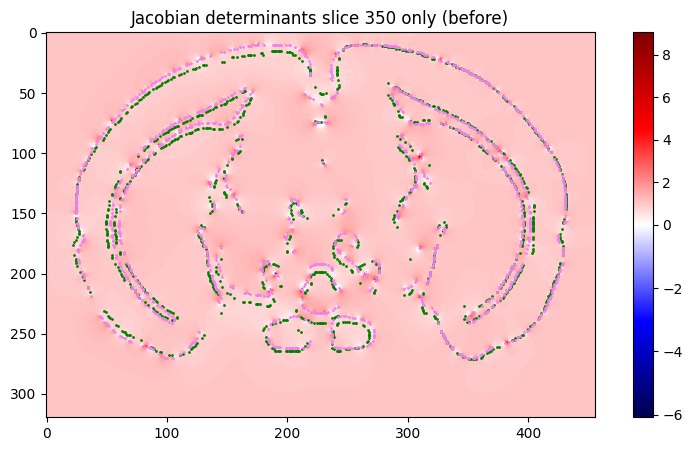

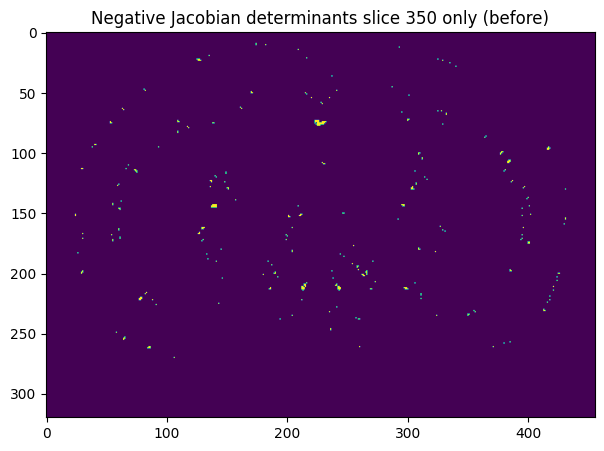

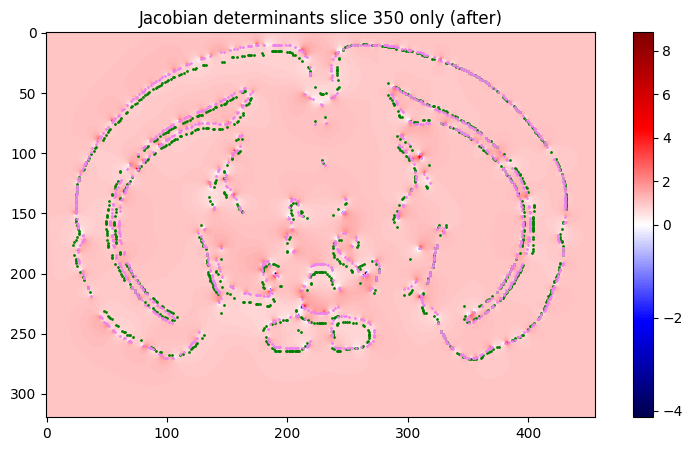

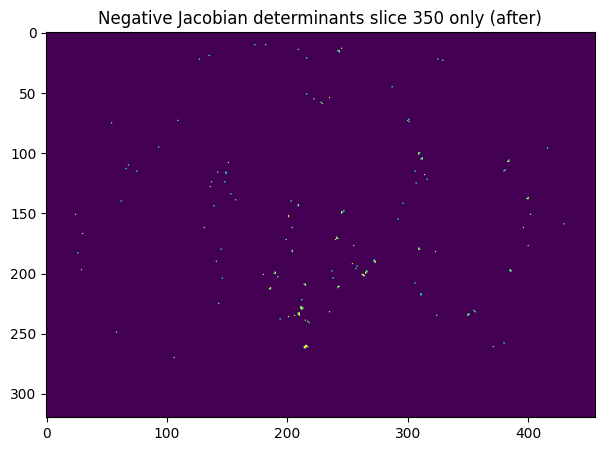

In [5]:
fixed_resolution = np.zeros((1, 320, 456))

# Compute the 3D Laplacian of the ORIGINAL points and retrieve the Jacobian determinant field
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints, fpoints)
jdet = jacobian.sitk_jacobian_determinant(deformation)

# Compute the 3D Laplacian of the NEW CORRECTED points and retrieve the Jacobian determinant field
deformation_corrected, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints_intersection_removed, fpoints_intersection_removed)
jdet_corrected = jacobian.sitk_jacobian_determinant(deformation_corrected)

# Print the number of negative or zero Jacobian determinants
print("\nBefore - number of negative or zero Jacobian determinants:", np.sum(jdet <= 0))
print("Before - minimum Jacobian determinant:", jdet.min())
print("Before - maximum Jacobian determinant:", jdet.max())
print()

print("After - number of negative or zero Jacobian determinants:", np.sum(jdet_corrected <= 0))
print("After - minimum Jacobian determinant:", jdet_corrected.min())
print("After - maximum Jacobian determinant:", jdet_corrected.max())

# Plot the Jacobian determinant values of the original
norm = mcolors.TwoSlopeNorm(vmin=min(jdet.min(), -1), vcenter=0, vmax=jdet.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints[:, 2], mpoints[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (before)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (before)")
plt.show()

# Plot the Jacobian determinant values of the corrected
norm = mcolors.TwoSlopeNorm(vmin=min(jdet_corrected.min(), -1), vcenter=0, vmax=jdet_corrected.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints_intersection_removed[:, 2], mpoints_intersection_removed[:, 1], c="g", s=1)
plt.scatter(fpoints_intersection_removed[:, 2], fpoints_intersection_removed[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (after)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (after)")
plt.show()

## Remove ORIENTATION outliers from correspondence points

In [6]:
MAX_DIST = 30
MAX_DEG = 60

mpoints_corrected = mpoints.copy()
fpoints_corrected = fpoints.copy()
cvectors_corrected = cvectors.copy()

# Process point orientations
outlier_found = True
num_runs = 0
total_outliers = 0
while outlier_found:
    outlier_found = False
    outlier_indices = []
    num_outliers = 0
    for i in range(len(fpoints_corrected)):
        curr_point = fpoints_corrected[i]
        curr_vector = cvectors_corrected[i]
        #print("Current point:", curr_point)
        neighborhood_idx, neighborhood = get_neighborhood(curr_point, fpoints_corrected, MAX_DIST)

        # Compute the average correspondence vector in the neighborhood
        average_vector = np.mean(cvectors_corrected[neighborhood_idx], axis=0)
        angle_rad, angle_deg = angle_between_vectors(average_vector, curr_vector)
        if angle_deg > MAX_DEG:
            num_outliers += 1
            outlier_indices.append(i)
            outlier_found = True
            #print(f"Point {i} has a large angle of {angle_deg:.2f} degrees")
            #print(angle_deg)

    # Remove outlier indices from moving and fixed points
    mpoints_corrected = np.delete(mpoints_corrected, outlier_indices, axis=0)
    fpoints_corrected = np.delete(fpoints_corrected, outlier_indices, axis=0)
    cvectors_corrected = np.delete(cvectors_corrected, outlier_indices, axis=0)
    
    print("Number of outliers:", num_outliers, f"out of {len(fpoints)} points")
    total_outliers += num_outliers
    num_runs += 1

print("\nNumber of runs:", num_runs)
print("Number of points removed:", total_outliers)
print("Number of points in the corrected points:", len(fpoints_corrected), "/", len(fpoints))

Number of outliers: 230 out of 1326 points
Number of outliers: 17 out of 1326 points
Number of outliers: 1 out of 1326 points
Number of outliers: 0 out of 1326 points

Number of runs: 4
Number of points removed: 248
Number of points in the corrected points: 1078 / 1326


## Compute Jacobian of orientation-filtered points

fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.055024147033691406s
Computing dy
dy calculated in 0.17067456245422363s
Computing dx
dx calculated in 0.2702906131744385s
SITK deformation shape: (1, 320, 456, 3)
fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.04578900337219238s
Computing dy
dy calculated in 0.20895767211914062s
Computing dx
dx calculated in 0.3237905502319336s
SITK deformation shape: (1, 320, 456, 3)

Before - number of negative or zero Jacobian determinants: 386
Before - minimum Jacobian determinant: -6.08035232834211
Before - maximum Jacobian determinant: 9.046598660636274

After - number of negative or zero Jacobian determinants: 177
After - minimum Jacobian determinant: -3.705544075115345
After - maximum Jacobian determinant: 6.613283330845526


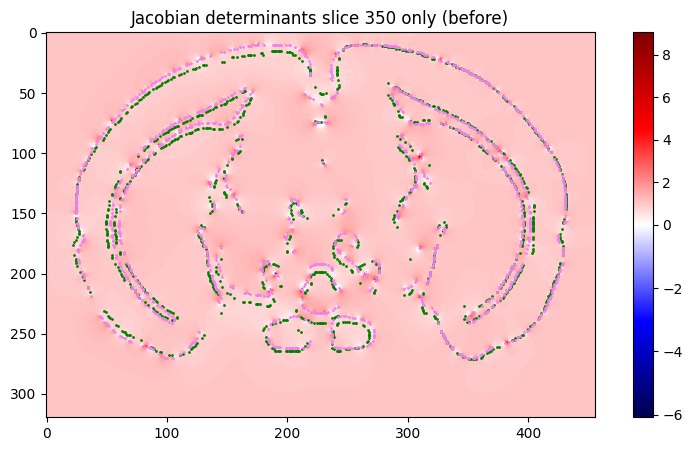

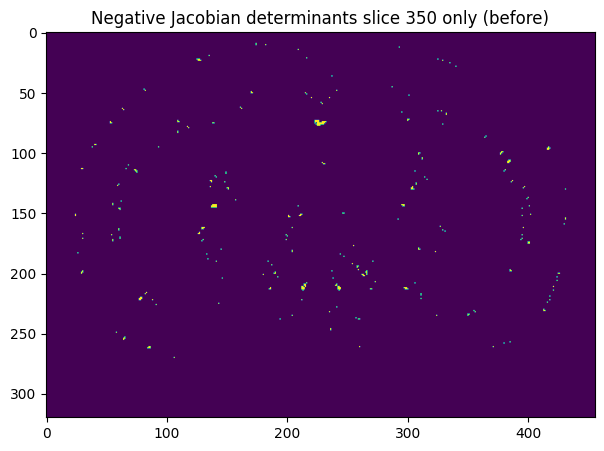

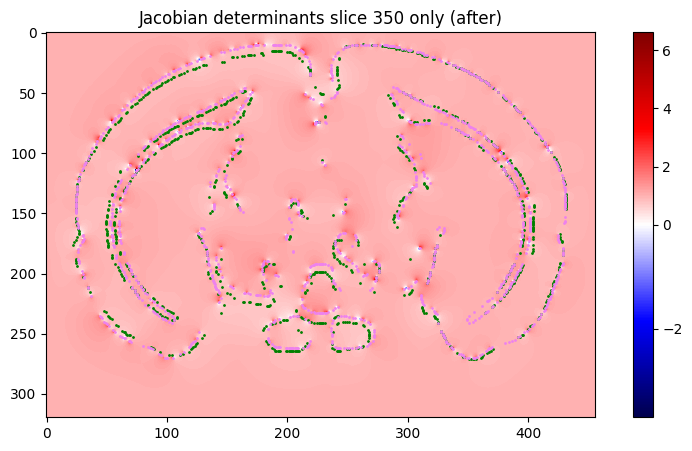

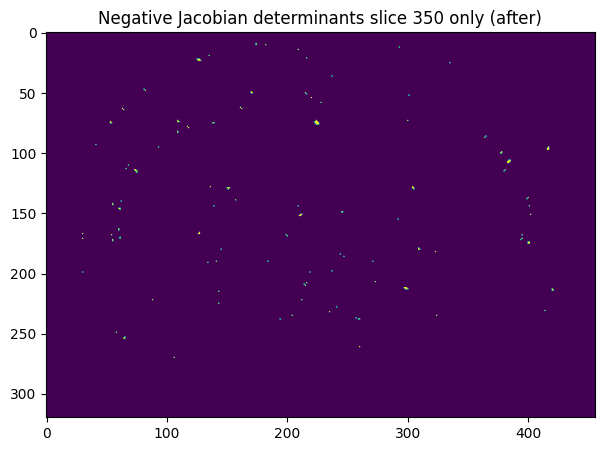

In [7]:
fixed_resolution = np.zeros((1, 320, 456))

# Compute the 3D Laplacian of the ORIGINAL points and retrieve the Jacobian determinant field
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints, fpoints)
jdet = jacobian.sitk_jacobian_determinant(deformation)

# Compute the 3D Laplacian of the NEW CORRECTED points and retrieve the Jacobian determinant field
deformation_corrected, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints_corrected, fpoints_corrected)
jdet_corrected = jacobian.sitk_jacobian_determinant(deformation_corrected)

# Print the number of negative or zero Jacobian determinants
print("\nBefore - number of negative or zero Jacobian determinants:", np.sum(jdet <= 0))
print("Before - minimum Jacobian determinant:", jdet.min())
print("Before - maximum Jacobian determinant:", jdet.max())
print()

print("After - number of negative or zero Jacobian determinants:", np.sum(jdet_corrected <= 0))
print("After - minimum Jacobian determinant:", jdet_corrected.min())
print("After - maximum Jacobian determinant:", jdet_corrected.max())

# Plot the Jacobian determinant values of the original
norm = mcolors.TwoSlopeNorm(vmin=min(jdet.min(), -1), vcenter=0, vmax=jdet.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints[:, 2], mpoints[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (before)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (before)")
plt.show()

# Plot the Jacobian determinant values of the corrected
norm = mcolors.TwoSlopeNorm(vmin=min(jdet_corrected.min(), -1), vcenter=0, vmax=jdet_corrected.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints_corrected[:, 2], mpoints_corrected[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (after)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (after)")
plt.show()

___

## Remove MAGNITUDE outliers

In [8]:
MAX_MAGNITUDE_MULT_GT = 0.5
MAX_MAGNITUDE_MULT_LT = 0.5
MAX_MAGNITUDE_DIFF_GT = 2
MAX_MAGNITUDE_DIFF_LT = 2
MAX_DIST = 20
DEBUG = False


mpoints_corrected = mpoints.copy()
fpoints_corrected = fpoints.copy()
cvectors_corrected = cvectors.copy()
magnitudes = np.linalg.norm(cvectors_corrected, axis=1)

# Process point magnitudes
outlier_found = True
num_runs = 0
total_outliers = 0
while outlier_found:
    outlier_found = False
    outlier_indices = []
    num_outliers = 0
    for i in range(len(fpoints_corrected)):
        curr_point = fpoints_corrected[i]
        curr_magnitude = magnitudes[i]
        #print("Current point:", curr_point)
        neighborhood_idx, neighborhood = get_neighborhood(curr_point, fpoints_corrected, MAX_DIST)

        # Compute the average correspondence vector in the neighborhood
        average_magnitude = np.mean(magnitudes[neighborhood_idx])
        median_magnitude = np.median(magnitudes[neighborhood_idx])
        std_magnitude = np.std(magnitudes[neighborhood_idx])
        
        if DEBUG:
            print("\nCurrent point:", curr_point)
            print("Current magnitude:", curr_magnitude)
            print("Average magnitude:", average_magnitude)
            print("Median magnitude:", median_magnitude)
            print("Standard deviation of magnitudes:", std_magnitude)
        
        # Remove the point if the magnitude is greater than the average magnitude by a certain threshold
        threshold_gt = max(average_magnitude + average_magnitude * MAX_MAGNITUDE_MULT_GT, 
                           average_magnitude + MAX_MAGNITUDE_DIFF_GT)
        if curr_magnitude > threshold_gt:
            num_outliers += 1
            outlier_indices.append(i)
            outlier_found = True
            print(f"Point {i} has a larger relative magnitude of {curr_magnitude} > {threshold_gt} ({average_magnitude}).")
            
        # Remove the point if the magnitude is less than the average magnitude by a certain threshold
        threshold_lt = max(average_magnitude - average_magnitude * MAX_MAGNITUDE_MULT_LT, 
                           average_magnitude - MAX_MAGNITUDE_DIFF_LT,
                           0)
        if curr_magnitude < threshold_lt and average_magnitude - MAX_MAGNITUDE_DIFF_LT > 0:
            num_outliers += 1
            outlier_indices.append(i)
            outlier_found = True
            print(f"Point {i} has a smaller relative magnitude of {curr_magnitude} < {threshold_lt} ({average_magnitude}).")

    # Remove outlier indices from moving and fixed points
    mpoints_corrected = np.delete(mpoints_corrected, outlier_indices, axis=0)
    fpoints_corrected = np.delete(fpoints_corrected, outlier_indices, axis=0)
    cvectors_corrected = np.delete(cvectors_corrected, outlier_indices, axis=0)
    
    print("Number of outliers:", num_outliers, f"out of {len(fpoints_corrected)} points")
    total_outliers += num_outliers
    num_runs += 1
    break

print("\nNumber of runs:", num_runs)
print("Number of points removed:", total_outliers)
print("Number of points in the corrected points:", len(fpoints_corrected), "/", len(fpoints))

Point 50 has a larger relative magnitude of 4.47213595499958 > 3.207213595499958 (1.2072135954999579).
Point 68 has a larger relative magnitude of 5.0 > 4.9799953278137 (2.979995327813701).
Point 72 has a larger relative magnitude of 5.830951894845301 > 5.021324625053363 (3.0213246250533627).
Point 79 has a larger relative magnitude of 9.219544457292887 > 7.8918708441517404 (5.261247229434494).
Point 81 has a larger relative magnitude of 9.219544457292887 > 7.8918708441517404 (5.261247229434494).
Point 88 has a larger relative magnitude of 6.0 > 3.824160450111475 (1.824160450111475).
Point 91 has a larger relative magnitude of 4.47213595499958 > 3.718897292216738 (1.718897292216738).
Point 94 has a larger relative magnitude of 4.47213595499958 > 3.3829524276059013 (1.3829524276059013).
Point 119 has a smaller relative magnitude of 0.0 < 3.1505101394170643 (5.150510139417064).
Point 125 has a smaller relative magnitude of 0.0 < 3.3169458057417165 (5.3169458057417165).
Point 128 has a sm

## Compute Jacobian of magnitude-filtered points

fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.05088448524475098s
Computing dy
dy calculated in 0.16729211807250977s
Computing dx
dx calculated in 0.26364755630493164s
SITK deformation shape: (1, 320, 456, 3)
fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.045804500579833984s
Computing dy
dy calculated in 0.17705392837524414s
Computing dx
dx calculated in 0.280184268951416s
SITK deformation shape: (1, 320, 456, 3)

Before - number of negative or zero Jacobian determinants: 386
Before - minimum Jacobian determinant: -6.08035232834211
Before - maximum Jacobian determinant: 9.046598660636274

After - number of negative or zero Jacobian determinants: 204
After - minimum Jacobian determinant: -3.9731419957669822
After - maximum Jacobian determinant: 7.441483621937265


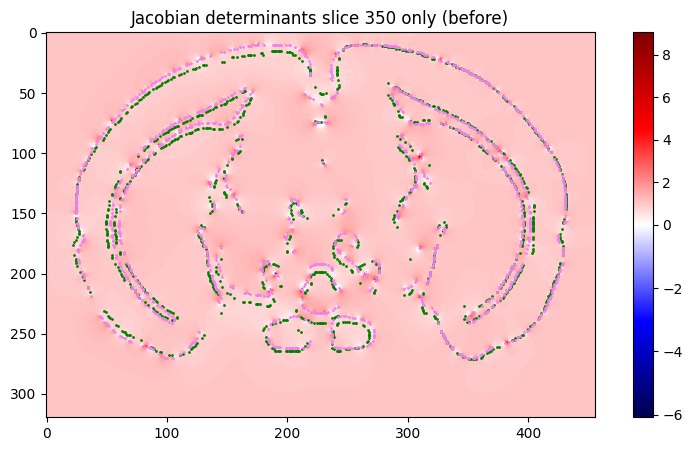

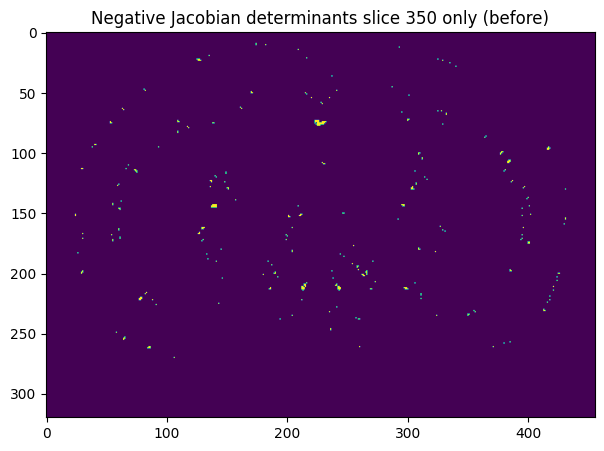

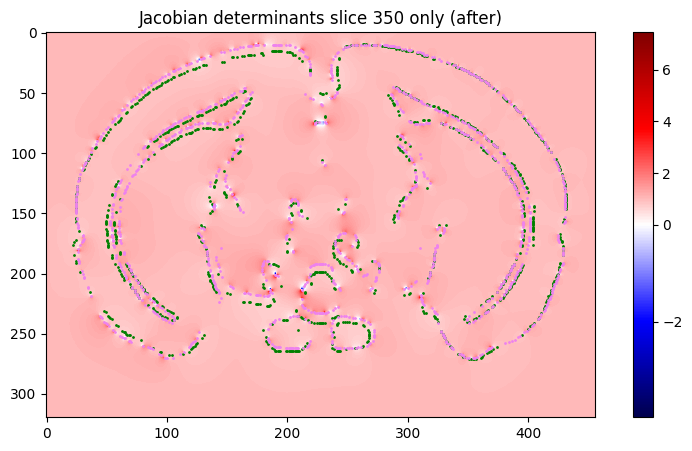

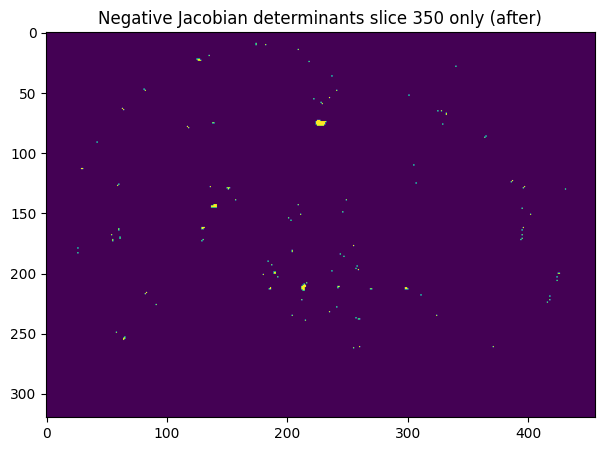

In [9]:
fixed_resolution = np.zeros((1, 320, 456))

# Compute the 3D Laplacian of the ORIGINAL points and retrieve the Jacobian determinant field
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints, fpoints)
jdet = jacobian.sitk_jacobian_determinant(deformation)

# Compute the 3D Laplacian of the NEW CORRECTED points and retrieve the Jacobian determinant field
deformation_corrected, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints_corrected, fpoints_corrected)
jdet_corrected = jacobian.sitk_jacobian_determinant(deformation_corrected)

# Print the number of negative or zero Jacobian determinants
print("\nBefore - number of negative or zero Jacobian determinants:", np.sum(jdet <= 0))
print("Before - minimum Jacobian determinant:", jdet.min())
print("Before - maximum Jacobian determinant:", jdet.max())
print()

print("After - number of negative or zero Jacobian determinants:", np.sum(jdet_corrected <= 0))
print("After - minimum Jacobian determinant:", jdet_corrected.min())
print("After - maximum Jacobian determinant:", jdet_corrected.max())

# Plot the Jacobian determinant values of the original
norm = mcolors.TwoSlopeNorm(vmin=min(jdet.min(), -1), vcenter=0, vmax=jdet.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints[:, 2], mpoints[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (before)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (before)")
plt.show()

# Plot the Jacobian determinant values of the corrected
norm = mcolors.TwoSlopeNorm(vmin=min(jdet_corrected.min(), -1), vcenter=0, vmax=jdet_corrected.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints_corrected[:, 2], mpoints_corrected[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (after)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (after)")
plt.show()

___
# Combine all

In [10]:
def get_negative_jdet_stats(jdet: np.ndarray, debug: bool = False) -> tuple:
    """
    Get the average, median, and standard deviation of the negative Jacobian determinants.
    
    Parameters:
    jdet (np.ndarray): The Jacobian determinant field.
    
    Returns:
    Tuple[float, float, float]: The average, median, standard deviation, min, and max of the negative Jacobian determinants.
    """
    negative_jdet = jdet[jdet <= 0]
    jdet_mean = np.mean(negative_jdet)
    jdet_median = np.median(negative_jdet)
    jdet_std = np.std(negative_jdet)
    jdet_min = negative_jdet.min()
    jdet_max = negative_jdet.max()
    if debug:
        print("Number of negative Jacobian determinants:", len(negative_jdet))
        print("Average negative Jacobian determinant:", jdet_mean)
        print("Median negative Jacobian determinant:", jdet_median)
        print("Standard deviation of negative Jacobian determinants:", jdet_std)
        print("Minimum negative Jacobian determinant:", jdet_min)
        print("Maximum negative Jacobian determinant:", jdet_max)
    return jdet_mean, jdet_median, jdet_std, jdet_min, jdet_max

### Run intersection removal

In [11]:
# Start with intersecting point removal
mpoints_intersection_removed, fpoints_intersection_removed = remove_intersections(mpoints, fpoints)
curr_mpoints = mpoints_intersection_removed.copy()
curr_fpoints = fpoints_intersection_removed.copy()
curr_cvectors = curr_fpoints - curr_mpoints

print("Starting number of correspondences:", mpoints.shape[0])
print("Number of correspondences after removing intersections:", mpoints_intersection_removed.shape[0])
print("Number of correspondences removed:", mpoints.shape[0] - mpoints_intersection_removed.shape[0])

Starting number of correspondences: 1326
Number of correspondences after removing intersections: 1246
Number of correspondences removed: 80


fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.051636695861816406s
Computing dy
dy calculated in 0.1637861728668213s
Computing dx
dx calculated in 0.25945591926574707s
SITK deformation shape: (1, 320, 456, 3)
fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.046366214752197266s
Computing dy
dy calculated in 0.17264842987060547s
Computing dx
dx calculated in 0.2763235569000244s
SITK deformation shape: (1, 320, 456, 3)

Base Jdet before modifications:
Number of negative Jacobian determinants: 386
Average negative Jacobian determinant: -0.5640707394702855
Median negative Jacobian determinant: -0.31449281575664245
Standard deviation of negative Jacobian determinants: 0.7454131492787323
Minimum negative Jacobian determinant: -6.08035232834211
Maximum negative Jacobian determinant: -0.00046179012442182366


Before - n

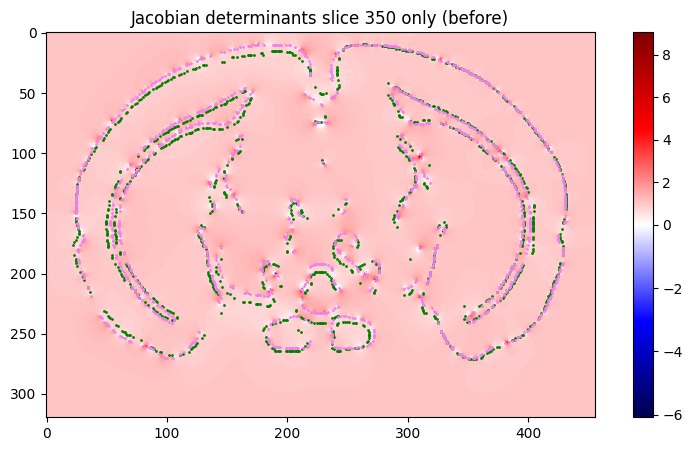

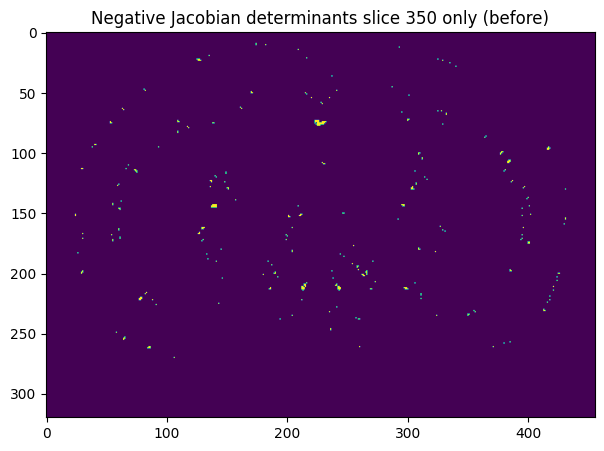

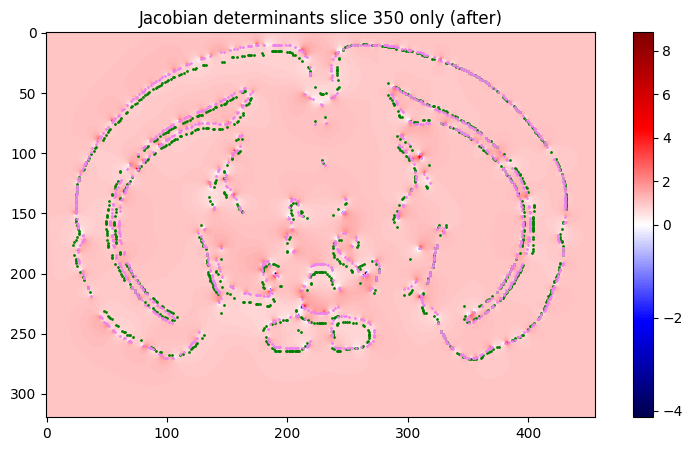

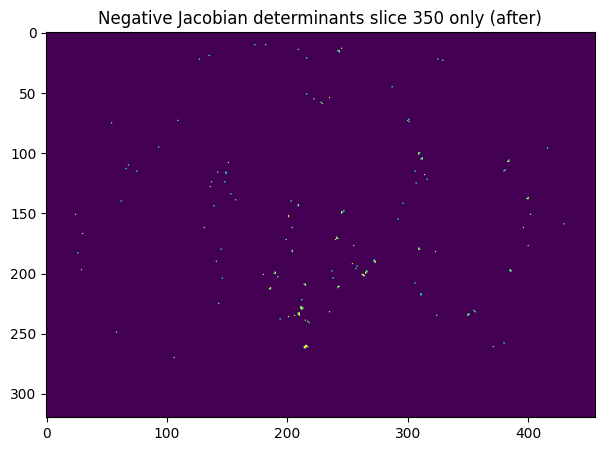

In [12]:
fixed_resolution = np.zeros((1, 320, 456))

# Compute the 3D Laplacian of the ORIGINAL points and retrieve the Jacobian determinant field
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints, fpoints)
jdet = jacobian.sitk_jacobian_determinant(deformation)

# Compute the 3D Laplacian of the NEW CORRECTED points and retrieve the Jacobian determinant field
deformation_corrected, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, curr_mpoints, curr_fpoints)
jdet_corrected = jacobian.sitk_jacobian_determinant(deformation_corrected)

print("\nBase Jdet before modifications:")
get_negative_jdet_stats(jdet, debug=True)
print()

# Print the number of negative or zero Jacobian determinants
print("\nBefore - number of negative or zero Jacobian determinants:", np.sum(jdet <= 0))
print("Before - minimum Jacobian determinant:", jdet.min())
print("Before - maximum Jacobian determinant:", jdet.max())
print()

print("After - number of negative or zero Jacobian determinants:", np.sum(jdet_corrected <= 0))
print("After - minimum Jacobian determinant:", jdet_corrected.min())
print("After - maximum Jacobian determinant:", jdet_corrected.max())
print()

get_negative_jdet_stats(jdet_corrected, debug=True)

# Plot the Jacobian determinant values of the original
norm = mcolors.TwoSlopeNorm(vmin=min(jdet.min(), -1), vcenter=0, vmax=jdet.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints[:, 2], mpoints[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (before)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (before)")
plt.show()

# Plot the Jacobian determinant values of the corrected
norm = mcolors.TwoSlopeNorm(vmin=min(jdet_corrected.min(), -1), vcenter=0, vmax=jdet_corrected.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(curr_mpoints[:, 2], curr_mpoints[:, 1], c="g", s=1)
plt.scatter(curr_fpoints[:, 2], curr_fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (after)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (after)")
plt.show()

### Run orientation removal

In [13]:
# Now remove orientation outliers
MAX_DIST = 30
MAX_DEG = 60  # 60 default

mpoints_corrected = curr_mpoints.copy()
fpoints_corrected = curr_fpoints.copy()
cvectors_corrected = curr_cvectors.copy()

# Process point orientations
outlier_found = True
num_runs = 0
total_outliers = 0
while outlier_found:
    outlier_found = False
    outlier_indices = []
    num_outliers = 0
    for i in range(len(fpoints_corrected)):
        curr_point = fpoints_corrected[i]
        curr_vector = cvectors_corrected[i]
        #print("Current point:", curr_point)
        neighborhood_idx, neighborhood = get_neighborhood(curr_point, fpoints_corrected, MAX_DIST)

        # Compute the average correspondence vector in the neighborhood
        average_vector = np.mean(cvectors_corrected[neighborhood_idx], axis=0)
        angle_rad, angle_deg = angle_between_vectors(average_vector, curr_vector)
        if angle_deg > MAX_DEG:
            num_outliers += 1
            outlier_indices.append(i)
            outlier_found = True
            #print(f"Point {i} has a large angle of {angle_deg:.2f} degrees")
            #print(angle_deg)

    # Remove outlier indices from moving and fixed points
    mpoints_corrected = np.delete(mpoints_corrected, outlier_indices, axis=0)
    fpoints_corrected = np.delete(fpoints_corrected, outlier_indices, axis=0)
    cvectors_corrected = np.delete(cvectors_corrected, outlier_indices, axis=0)
    
    print("Number of outliers:", num_outliers, f"out of {len(curr_fpoints)} points")
    total_outliers += num_outliers
    num_runs += 1

print("\nNumber of runs:", num_runs)
print("Number of points removed:", total_outliers)
print("Number of points in the corrected points:", len(fpoints_corrected), "/", len(curr_fpoints))

curr_mpoints = mpoints_corrected.copy()
curr_fpoints = fpoints_corrected.copy()
curr_cvectors = curr_fpoints - curr_mpoints

Number of outliers: 184 out of 1246 points
Number of outliers: 18 out of 1246 points
Number of outliers: 7 out of 1246 points
Number of outliers: 2 out of 1246 points
Number of outliers: 1 out of 1246 points
Number of outliers: 0 out of 1246 points

Number of runs: 6
Number of points removed: 212
Number of points in the corrected points: 1034 / 1246


### Check intermediary Jacobian

fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.05329251289367676s
Computing dy
dy calculated in 0.17170023918151855s
Computing dx
dx calculated in 0.27156996726989746s
SITK deformation shape: (1, 320, 456, 3)
fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.04679393768310547s
Computing dy
dy calculated in 0.19121980667114258s
Computing dx
dx calculated in 0.3100743293762207s
SITK deformation shape: (1, 320, 456, 3)

Before - number of negative or zero Jacobian determinants: 386
Before - minimum Jacobian determinant: -6.08035232834211
Before - maximum Jacobian determinant: 9.046598660636274

After - number of negative or zero Jacobian determinants: 92
After - minimum Jacobian determinant: -3.473978516992518
After - maximum Jacobian determinant: 5.79103541966788

Number of negative Jacobian determinants: 92
Avera

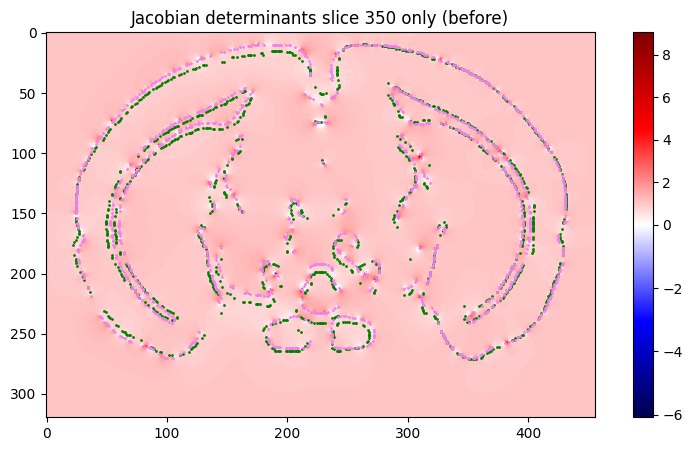

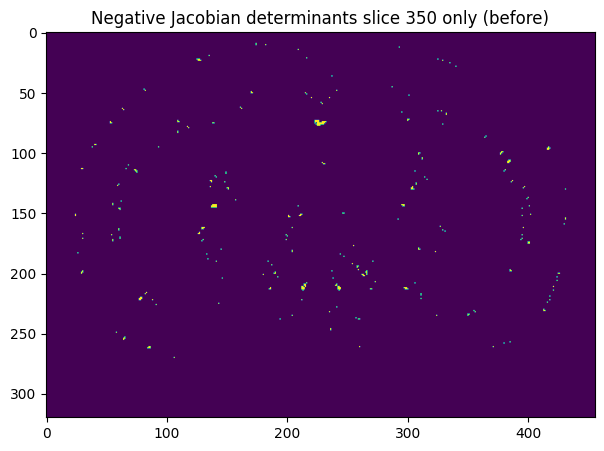

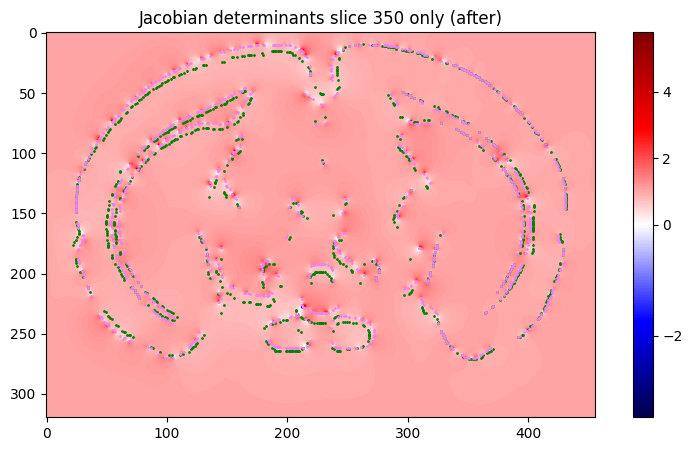

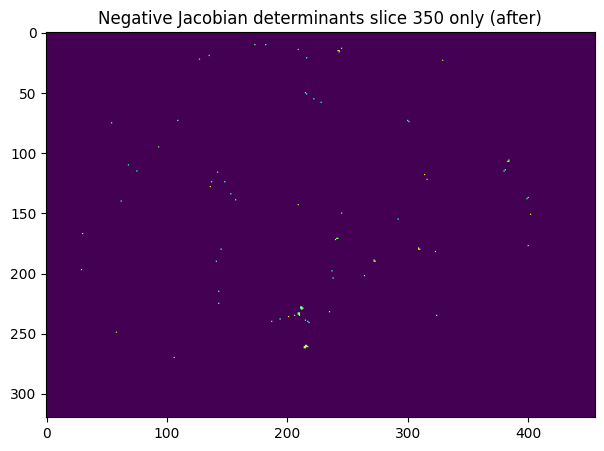

In [14]:
fixed_resolution = np.zeros((1, 320, 456))

# Compute the 3D Laplacian of the ORIGINAL points and retrieve the Jacobian determinant field
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints, fpoints)
jdet = jacobian.sitk_jacobian_determinant(deformation)

# Compute the 3D Laplacian of the NEW CORRECTED points and retrieve the Jacobian determinant field
deformation_corrected, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, curr_mpoints, curr_fpoints)
jdet_corrected = jacobian.sitk_jacobian_determinant(deformation_corrected)

# Print the number of negative or zero Jacobian determinants
print("\nBefore - number of negative or zero Jacobian determinants:", np.sum(jdet <= 0))
print("Before - minimum Jacobian determinant:", jdet.min())
print("Before - maximum Jacobian determinant:", jdet.max())
print()

print("After - number of negative or zero Jacobian determinants:", np.sum(jdet_corrected <= 0))
print("After - minimum Jacobian determinant:", jdet_corrected.min())
print("After - maximum Jacobian determinant:", jdet_corrected.max())
print() 

get_negative_jdet_stats(jdet_corrected, debug=True)

# Plot the Jacobian determinant values of the original
norm = mcolors.TwoSlopeNorm(vmin=min(jdet.min(), -1), vcenter=0, vmax=jdet.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints[:, 2], mpoints[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (before)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (before)")
plt.show()

# Plot the Jacobian determinant values of the corrected
norm = mcolors.TwoSlopeNorm(vmin=min(jdet_corrected.min(), -1), vcenter=0, vmax=jdet_corrected.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(curr_mpoints[:, 2], curr_mpoints[:, 1], c="g", s=1)
plt.scatter(curr_fpoints[:, 2], curr_fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (after)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (after)")
plt.show()

### Run magnitude removal

In [15]:
# Now run magnitude
MAX_MAGNITUDE_MULT_GT = 0.5
MAX_MAGNITUDE_MULT_LT = 0.5
MAX_MAGNITUDE_DIFF_GT = 2
MAX_MAGNITUDE_DIFF_LT = 2
MAX_DIST = 20
DEBUG = False


mpoints_corrected = curr_mpoints.copy()
fpoints_corrected = curr_fpoints.copy()
cvectors_corrected = curr_cvectors.copy()
magnitudes = np.linalg.norm(cvectors_corrected, axis=1)

# Process point magnitudes
outlier_found = True
num_runs = 0
total_outliers = 0
while outlier_found:
    outlier_found = False
    outlier_indices = []
    num_outliers = 0
    for i in range(len(fpoints_corrected)):
        curr_point = fpoints_corrected[i]
        curr_magnitude = magnitudes[i]
        #print("Current point:", curr_point)
        neighborhood_idx, neighborhood = get_neighborhood(curr_point, fpoints_corrected, MAX_DIST)

        # Compute the average correspondence vector in the neighborhood
        average_magnitude = np.mean(magnitudes[neighborhood_idx])
        median_magnitude = np.median(magnitudes[neighborhood_idx])
        std_magnitude = np.std(magnitudes[neighborhood_idx])
        
        if DEBUG:
            print("\nCurrent point:", curr_point)
            print("Current magnitude:", curr_magnitude)
            print("Average magnitude:", average_magnitude)
            print("Median magnitude:", median_magnitude)
            print("Standard deviation of magnitudes:", std_magnitude)
        
        # Remove the point if the magnitude is greater than the average magnitude by a certain threshold
        threshold_gt = max(average_magnitude + average_magnitude * MAX_MAGNITUDE_MULT_GT, 
                           average_magnitude + MAX_MAGNITUDE_DIFF_GT)
        if curr_magnitude > threshold_gt:
            num_outliers += 1
            outlier_indices.append(i)
            outlier_found = True
            print(f"Point {i} has a larger relative magnitude of {curr_magnitude} > {threshold_gt} ({average_magnitude}).")
            
        # Remove the point if the magnitude is less than the average magnitude by a certain threshold
        threshold_lt = max(average_magnitude - average_magnitude * MAX_MAGNITUDE_MULT_LT, 
                           average_magnitude - MAX_MAGNITUDE_DIFF_LT,
                           0)
        if curr_magnitude < threshold_lt and average_magnitude - MAX_MAGNITUDE_DIFF_LT > 0:
            num_outliers += 1
            outlier_indices.append(i)
            outlier_found = True
            print(f"Point {i} has a smaller relative magnitude of {curr_magnitude} < {threshold_lt} ({average_magnitude}).")

    # Remove outlier indices from moving and fixed points
    mpoints_corrected = np.delete(mpoints_corrected, outlier_indices, axis=0)
    fpoints_corrected = np.delete(fpoints_corrected, outlier_indices, axis=0)
    cvectors_corrected = np.delete(cvectors_corrected, outlier_indices, axis=0)
    
    print("Number of outliers:", num_outliers, f"out of {len(fpoints_corrected)} points")
    total_outliers += num_outliers
    num_runs += 1
    break

print("\n\nNumber of runs:", num_runs)
print("Number of points removed:", total_outliers)
print("Number of points in the corrected points:", len(fpoints_corrected), "/", len(curr_fpoints))

curr_mpoints = mpoints_corrected.copy()
curr_fpoints = fpoints_corrected.copy()
curr_cvectors = curr_fpoints - curr_mpoints

Point 33 has a smaller relative magnitude of 0.0 < 1.1765306226698662 (2.3530612453397324).
Point 47 has a larger relative magnitude of 7.211102550927978 > 5.236923245394814 (3.236923245394814).
Point 48 has a larger relative magnitude of 3.605551275463989 > 3.1630286277012187 (1.163028627701219).
Point 61 has a smaller relative magnitude of 0.0 < 1.4200713635801094 (2.840142727160219).
Point 65 has a larger relative magnitude of 5.830951894845301 > 5.308412907387316 (3.3084129073873156).
Point 72 has a larger relative magnitude of 9.219544457292887 > 7.725952270616403 (5.150634847077602).
Point 74 has a larger relative magnitude of 9.219544457292887 > 7.725952270616403 (5.150634847077602).
Point 80 has a larger relative magnitude of 4.47213595499958 > 3.0476517761412576 (1.0476517761412576).
Point 105 has a smaller relative magnitude of 0.0 < 2.9985639364982966 (4.998563936498297).
Point 110 has a smaller relative magnitude of 0.0 < 3.162296223352196 (5.162296223352196).
Point 112 has

In [16]:
print("Final number of correspondences:", curr_mpoints.shape[0])

Final number of correspondences: 892


## Compute Jacobian of final combined operation

fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.0509490966796875s
Computing dy
dy calculated in 0.16834020614624023s
Computing dx
dx calculated in 0.265460729598999s
SITK deformation shape: (1, 320, 456, 3)
fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.04633665084838867s
Computing dy
dy calculated in 0.18928217887878418s
Computing dx
dx calculated in 0.3187105655670166s
SITK deformation shape: (1, 320, 456, 3)

Before - number of negative or zero Jacobian determinants: 386
Before - minimum Jacobian determinant: -6.08035232834211
Before - maximum Jacobian determinant: 9.046598660636274

After - number of negative or zero Jacobian determinants: 27
After - minimum Jacobian determinant: -0.8647245957286207
After - maximum Jacobian determinant: 3.9868281439344906

Number of negative Jacobian determinants: 27
Avera

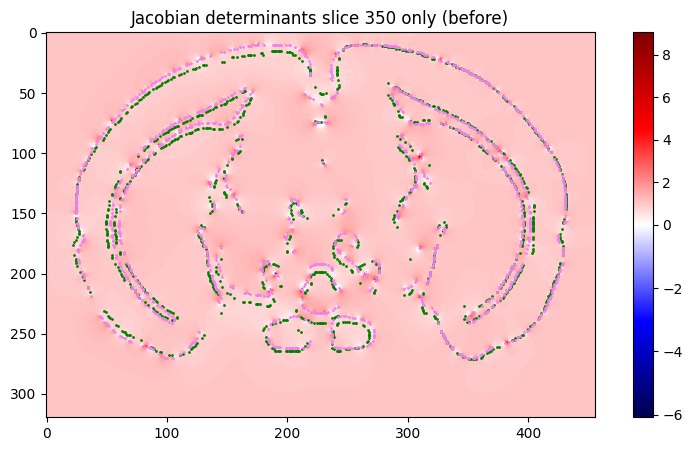

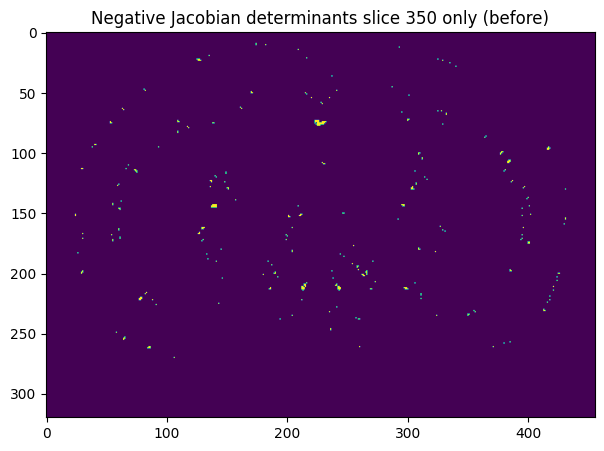

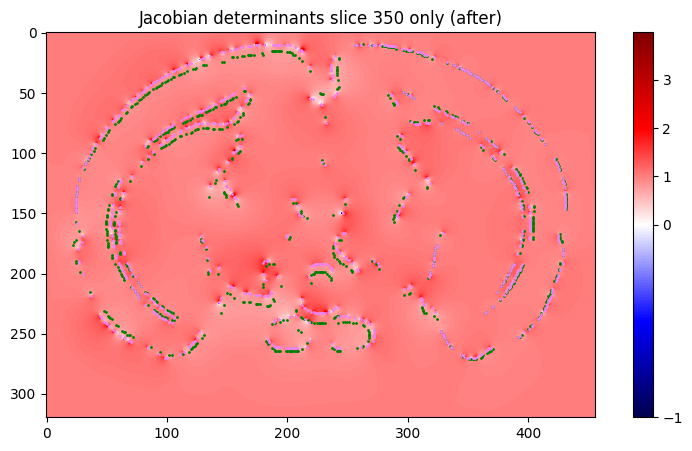

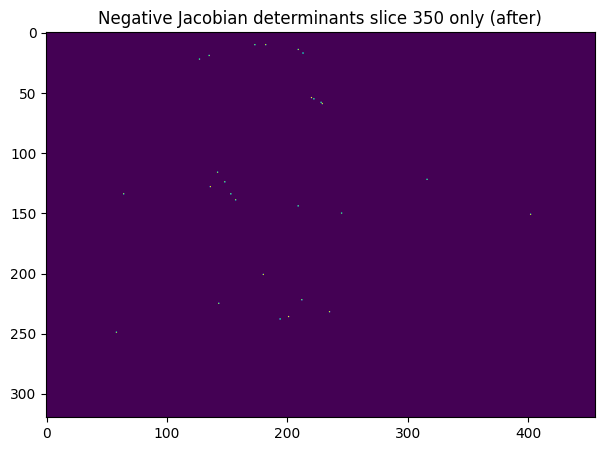

In [17]:
fixed_resolution = np.zeros((1, 320, 456))

# Compute the 3D Laplacian of the ORIGINAL points and retrieve the Jacobian determinant field
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints, fpoints)
jdet = jacobian.sitk_jacobian_determinant(deformation)

# Compute the 3D Laplacian of the NEW CORRECTED points and retrieve the Jacobian determinant field
deformation_corrected, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, curr_mpoints, curr_fpoints)
jdet_corrected = jacobian.sitk_jacobian_determinant(deformation_corrected)

# Print the number of negative or zero Jacobian determinants
print("\nBefore - number of negative or zero Jacobian determinants:", np.sum(jdet <= 0))
print("Before - minimum Jacobian determinant:", jdet.min())
print("Before - maximum Jacobian determinant:", jdet.max())
print()

print("After - number of negative or zero Jacobian determinants:", np.sum(jdet_corrected <= 0))
print("After - minimum Jacobian determinant:", jdet_corrected.min())
print("After - maximum Jacobian determinant:", jdet_corrected.max())
print()

get_negative_jdet_stats(jdet_corrected, debug=True)

# Plot the Jacobian determinant values of the original
norm = mcolors.TwoSlopeNorm(vmin=min(jdet.min(), -1), vcenter=0, vmax=jdet.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints[:, 2], mpoints[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (before)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (before)")
plt.show()

# Plot the Jacobian determinant values of the corrected
norm = mcolors.TwoSlopeNorm(vmin=min(jdet_corrected.min(), -1), vcenter=0, vmax=jdet_corrected.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(curr_mpoints[:, 2], curr_mpoints[:, 1], c="g", s=1)
plt.scatter(curr_fpoints[:, 2], curr_fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (after)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (after)")
plt.show()

In [21]:
# Save the final corrected correspondences
#np.save("output/mpoints_27.npy", curr_mpoints)
#np.save("output/fpoints_27.npy", curr_fpoints)
#np.save("output/deformation_27.npy", deformation_corrected)
#np.save("output/jdet_27.npy", jdet_corrected)

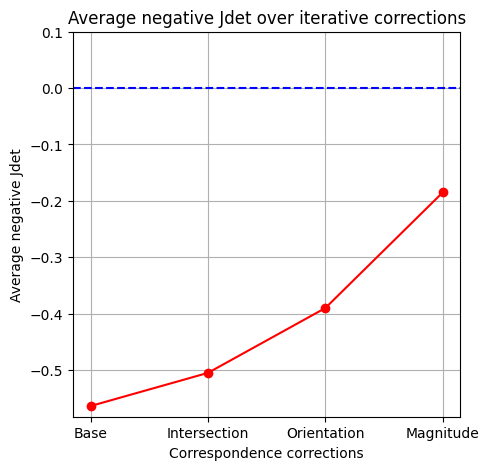

In [33]:
# Plot average negative Jdets (overall severity)

# Values to plot
values = [-0.56407, -0.50526, -0.39018, -0.18502]

f = plt.figure(figsize=(5, 5))

# Create a line plot
plt.plot(values, marker='o', linestyle='-', color='r')

# Add labels and title
plt.xlabel('Correspondence corrections')
plt.xticks([0, 1, 2, 3], ['Base', 'Intersection', 'Orientation', 'Magnitude'])
plt.ylabel('Average negative Jdet')
plt.ylim(top=0.1)
plt.title('Average negative Jdet over iterative corrections')

# Draw a horizontal line at y = 0
plt.axhline(y=0, color='b', linestyle='--')

# Show the plot
plt.grid(True)
plt.show()
f.clear()
plt.close(f)

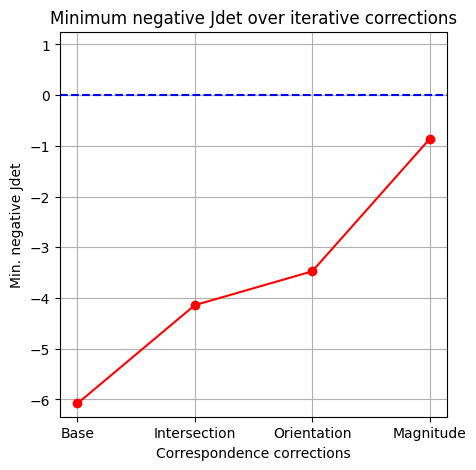

In [38]:
# Plot minimum Jdet values (worst case)

# Values to plot
values = [-6.08035, -4.14126, -3.47397, -0.86472]

f = plt.figure(figsize=(5, 5))

# Create a line plot
plt.plot(values, marker='o', linestyle='-', color='r')

# Add labels and title
plt.xlabel('Correspondence corrections')
plt.xticks([0, 1, 2, 3], ['Base', 'Intersection', 'Orientation', 'Magnitude'])
plt.ylabel('Min. negative Jdet')
plt.ylim(top=1.25)
plt.title('Minimum negative Jdet over iterative corrections')

# Draw a horizontal line at y = 0
plt.axhline(y=0, color='b', linestyle='--')

# Show the plot
plt.grid(True)
plt.show()
f.clear()
plt.close(f)

___
# Run analysis on output

In [57]:
def get_negative_jdet_coords(jdet: np.ndarray) -> np.ndarray:
    """
    Get the coordinates of the negative Jacobian determinants.
    
    Parameters:
    jdet (np.ndarray): The Jacobian determinant field.
    
    Returns:
    np.ndarray: The coordinates of the negative Jacobian determinants.
    """
    return np.argwhere(jdet <= 0)


import matplotlib.patheffects as path_effects


def show_point(coord: np.ndarray, deformation: np.ndarray, jdet: np.ndarray, fpoints: np.ndarray=None, n: int=5):
    """
    Shows a plot of n x n points around a coordinate.
    
    Parameters:
    coord (np.ndarray): The coordinate.
    deformation (np.ndarray): The deformation field.
    jdet (np.ndarray): The Jacobian determinant field.
    fpoints (np.ndarray): The fixed points (optional).
    n (int): The size of the grid centering the current coordinate. Should be an odd number, otherwise size is increased + 1.
    """
    # Get the n x n points around the coordinate
    z, y, x = coord
    y_min = max(y - (n // 2), 0)
    y_max = min(y + (n // 2), jdet.shape[1])
    x_min = max(x - (n // 2), 0)
    x_max = min(x + (n // 2), jdet.shape[2])
    
    # Get only fpoints from the current slice if any are provided
    if fpoints is not None:
        fpoints = fpoints[fpoints[:, 0] == coord[0]]
    
    # Adjust font size based on n
    font_size = max(8, 16 - n)
    
    # Normalize the colorbar for the Jacobian determinant field
    norm = mcolors.TwoSlopeNorm(vmin=min(jdet.min(), -1), vcenter=0, vmax=jdet.max())
    
    # Subplot 1: Plot the Jacobian determinant field
    gridspec = {'width_ratios': [1, 1, 0.1]}
    fig, ax = plt.subplots(1, 3, figsize=(10, 5), gridspec_kw=gridspec)
    im = ax[0].imshow(jdet[0], cmap="seismic", norm=norm, interpolation='nearest')
    ax[0].set_xlim(x_min - 0.5, x_max + 0.5)
    ax[0].set_ylim(y_max + 0.5, y_min - 0.5)
    ax[0].set_title(f"Jacobian determinant field\n{tuple(coord)}")
    
    # Write the jacobian determinant values on the plot
    for j in range(y_min, y_max + 1):
        for i in range(x_min, x_max + 1):
            is_negative_jdet = (jdet[0, j, i] <= 0)
            if is_negative_jdet:
                text_color = 'blue'
                text_weight = 'bold'
            else:
                text_color = 'black'
                text_weight = 'normal'
            t = ax[0].text(i, j, f"{jdet[0, j, i]:.2f}", ha='center', va='center', color=text_color, fontsize=font_size, weight=text_weight)
            if is_negative_jdet:
                t.set_path_effects([path_effects.Stroke(linewidth=1, foreground="white"), path_effects.Normal()])
    
    # Subplot 2: Plot the displacement vector field
    ax[1].imshow(jdet[0], cmap="seismic", norm=norm, interpolation='nearest')
    for j in range(y_min, y_max + 1):
        for i in range(x_min, x_max + 1):
            y_displacement = deformation[2][0][j][i]
            x_displacement = deformation[1][0][j][i]
            
            # Adjust the magnitude for visual clarity
            magnitude = np.sqrt(y_displacement**2 + x_displacement**2) * 2
            adjusted_y_displacement = y_displacement
            adjusted_x_displacement = x_displacement
            if magnitude != 0:
                adjusted_y_displacement /= magnitude
                adjusted_x_displacement /= magnitude
                
            # If the point is a correspondence, color green, otherwise make it black
            is_correspondence = fpoints is not None and any(np.array_equal((coord[0], j, i), arr) for arr in fpoints)
            if is_correspondence: 
                arrow_color = 'green'
            else:
                arrow_color = 'black'
                
            # Plot the displacement vector
            ax[1].annotate(
                '', 
                xy=(i + adjusted_x_displacement, j + adjusted_y_displacement), 
                xytext=(i, j), 
                arrowprops=dict(color=arrow_color, shrink=0.045, headwidth=4, headlength=4.5, width=0.75)
            )
            
            # Color based on Jacobian determinant value
            is_negative_jdet = (jdet[0, j, i] <= 0)
            if is_negative_jdet:  # If the Jacobian determinant is negative, color blue/bold
                text_color = 'blue'
                text_weight = 'bold'
            elif is_correspondence:  # If the point is a correspondence, color green/bold
                text_color = 'green'
                text_weight = 'bold'
            else:  # If the Jacobian determinant is positive, color black/normal
                text_color = 'black'
                text_weight = 'normal'
            # Set text of displacement vector
            t = ax[1].text(i, j, f"{round(y_displacement, 2)}\n\n{round(x_displacement, 2)}", ha='center', va='center', color=text_color, weight=text_weight, fontsize=font_size)
            if is_negative_jdet:
                t.set_path_effects([path_effects.Stroke(linewidth=1, foreground="white"), path_effects.Normal()])


    # Ensure x and y axes show integer coordinates
    ax[1].set_xlim(x_min - 0.5, x_max + 0.5)
    ax[1].set_ylim(y_max + 0.5, y_min - 0.5)
    ax[1].set_title(f"Displacement field\n{tuple(coord)}")
    for axis in ax:
        axis.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        axis.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
       
    # Create a colorbar for the Jacobian determinant field
    cax = ax[2]
    plt.colorbar(im, cax=cax)
    plt.tight_layout()
    plt.show()

    # Clear from memory
    fig.clear()
    plt.close(fig)

## Try specific indices

JDET INDEX: 0
(0, 10, 173) -0.04322329000574181
(0, 10, 182) -0.4615082473406252
(0, 14, 209) -0.18565176137380068
(0, 17, 213) -0.10382806479430441
(0, 19, 135) -0.12231073669278755
(0, 22, 127) -0.43775160808278074
(0, 54, 220) -0.01662967757469775
(0, 55, 222) -0.2094807825718189
(0, 58, 228) -0.1988870109366243
(0, 59, 229) -0.044633504475831226
(0, 116, 142) -0.0834511505923656
(0, 122, 316) -0.26293143368296906
(0, 124, 148) -0.07400007714216572
(0, 128, 136) -0.39328717612863245
(0, 134, 64) -0.04155411056144314
(0, 134, 153) -0.028463799192673056
(0, 139, 157) -0.000987044747038153
(0, 144, 209) -0.065683482403479
(0, 150, 245) -0.8647245957286207
(0, 151, 402) -0.12828712647346555
(0, 201, 180) -0.03980520071925282
(0, 222, 212) -0.05613230548972591
(0, 225, 143) -0.5461647730183096
(0, 232, 235) -0.3575078901120002
(0, 236, 201) -0.09607994258469835
(0, 238, 194) -0.04633665692235347
(0, 249, 58) -0.08626580725464024

Current Jdet coordinate index: 0
Number of negative Jdet c

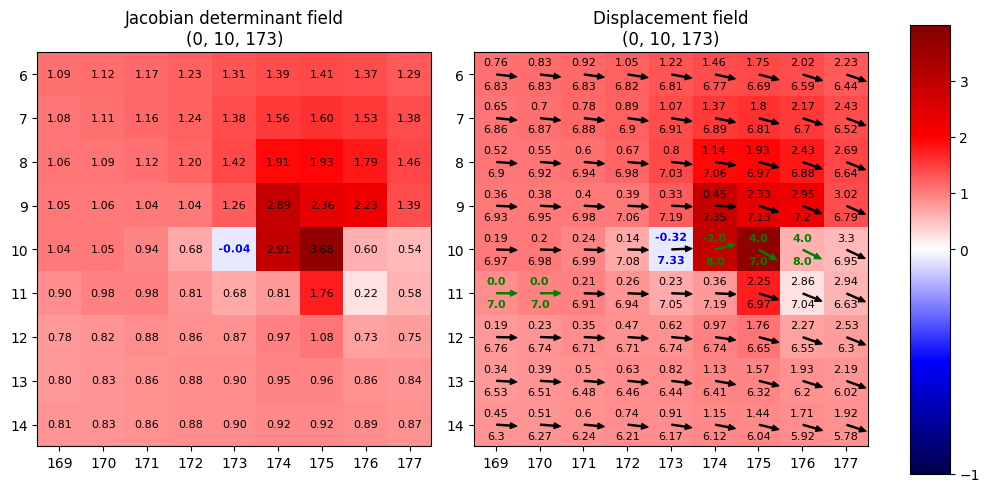



JDET INDEX: 1
(0, 10, 173) -0.04322329000574181
(0, 10, 182) -0.4615082473406252
(0, 14, 209) -0.18565176137380068
(0, 17, 213) -0.10382806479430441
(0, 19, 135) -0.12231073669278755
(0, 22, 127) -0.43775160808278074
(0, 54, 220) -0.01662967757469775
(0, 55, 222) -0.2094807825718189
(0, 58, 228) -0.1988870109366243
(0, 59, 229) -0.044633504475831226
(0, 116, 142) -0.0834511505923656
(0, 122, 316) -0.26293143368296906
(0, 124, 148) -0.07400007714216572
(0, 128, 136) -0.39328717612863245
(0, 134, 64) -0.04155411056144314
(0, 134, 153) -0.028463799192673056
(0, 139, 157) -0.000987044747038153
(0, 144, 209) -0.065683482403479
(0, 150, 245) -0.8647245957286207
(0, 151, 402) -0.12828712647346555
(0, 201, 180) -0.03980520071925282
(0, 222, 212) -0.05613230548972591
(0, 225, 143) -0.5461647730183096
(0, 232, 235) -0.3575078901120002
(0, 236, 201) -0.09607994258469835
(0, 238, 194) -0.04633665692235347
(0, 249, 58) -0.08626580725464024

Current Jdet coordinate index: 1
Number of negative Jdet

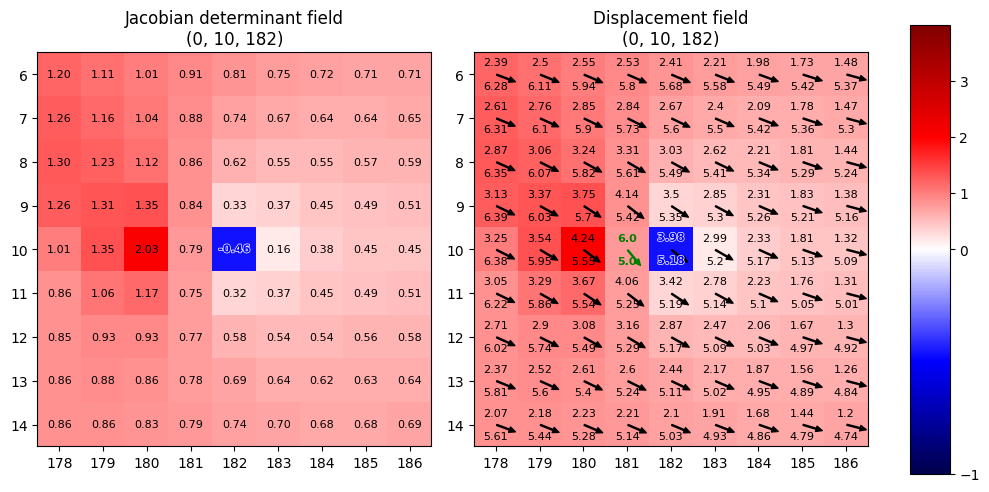



JDET INDEX: 2
(0, 10, 173) -0.04322329000574181
(0, 10, 182) -0.4615082473406252
(0, 14, 209) -0.18565176137380068
(0, 17, 213) -0.10382806479430441
(0, 19, 135) -0.12231073669278755
(0, 22, 127) -0.43775160808278074
(0, 54, 220) -0.01662967757469775
(0, 55, 222) -0.2094807825718189
(0, 58, 228) -0.1988870109366243
(0, 59, 229) -0.044633504475831226
(0, 116, 142) -0.0834511505923656
(0, 122, 316) -0.26293143368296906
(0, 124, 148) -0.07400007714216572
(0, 128, 136) -0.39328717612863245
(0, 134, 64) -0.04155411056144314
(0, 134, 153) -0.028463799192673056
(0, 139, 157) -0.000987044747038153
(0, 144, 209) -0.065683482403479
(0, 150, 245) -0.8647245957286207
(0, 151, 402) -0.12828712647346555
(0, 201, 180) -0.03980520071925282
(0, 222, 212) -0.05613230548972591
(0, 225, 143) -0.5461647730183096
(0, 232, 235) -0.3575078901120002
(0, 236, 201) -0.09607994258469835
(0, 238, 194) -0.04633665692235347
(0, 249, 58) -0.08626580725464024

Current Jdet coordinate index: 2
Number of negative Jdet

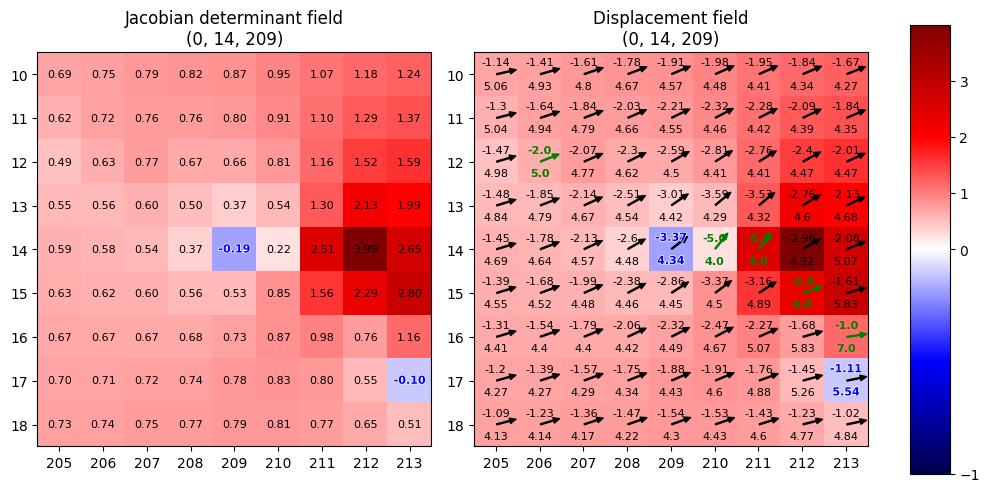



JDET INDEX: 3
(0, 10, 173) -0.04322329000574181
(0, 10, 182) -0.4615082473406252
(0, 14, 209) -0.18565176137380068
(0, 17, 213) -0.10382806479430441
(0, 19, 135) -0.12231073669278755
(0, 22, 127) -0.43775160808278074
(0, 54, 220) -0.01662967757469775
(0, 55, 222) -0.2094807825718189
(0, 58, 228) -0.1988870109366243
(0, 59, 229) -0.044633504475831226
(0, 116, 142) -0.0834511505923656
(0, 122, 316) -0.26293143368296906
(0, 124, 148) -0.07400007714216572
(0, 128, 136) -0.39328717612863245
(0, 134, 64) -0.04155411056144314
(0, 134, 153) -0.028463799192673056
(0, 139, 157) -0.000987044747038153
(0, 144, 209) -0.065683482403479
(0, 150, 245) -0.8647245957286207
(0, 151, 402) -0.12828712647346555
(0, 201, 180) -0.03980520071925282
(0, 222, 212) -0.05613230548972591
(0, 225, 143) -0.5461647730183096
(0, 232, 235) -0.3575078901120002
(0, 236, 201) -0.09607994258469835
(0, 238, 194) -0.04633665692235347
(0, 249, 58) -0.08626580725464024

Current Jdet coordinate index: 3
Number of negative Jdet

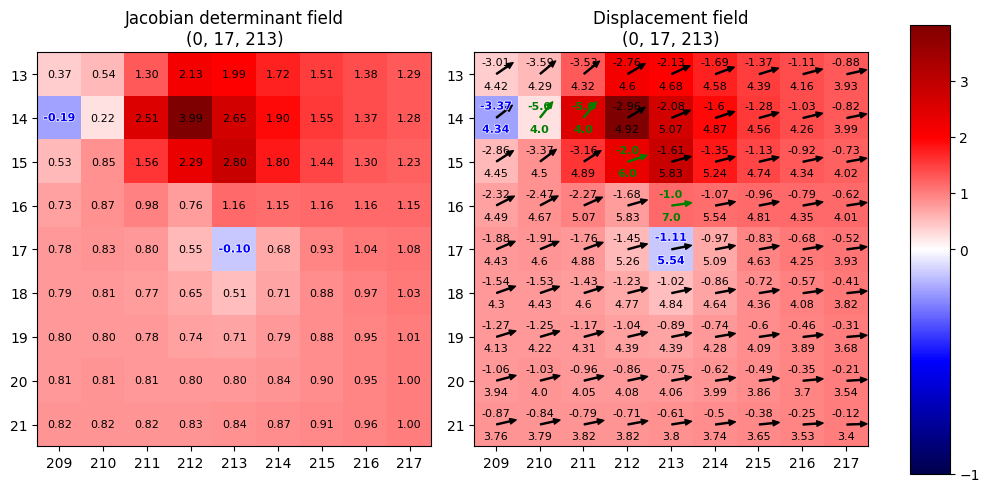



JDET INDEX: 4
(0, 10, 173) -0.04322329000574181
(0, 10, 182) -0.4615082473406252
(0, 14, 209) -0.18565176137380068
(0, 17, 213) -0.10382806479430441
(0, 19, 135) -0.12231073669278755
(0, 22, 127) -0.43775160808278074
(0, 54, 220) -0.01662967757469775
(0, 55, 222) -0.2094807825718189
(0, 58, 228) -0.1988870109366243
(0, 59, 229) -0.044633504475831226
(0, 116, 142) -0.0834511505923656
(0, 122, 316) -0.26293143368296906
(0, 124, 148) -0.07400007714216572
(0, 128, 136) -0.39328717612863245
(0, 134, 64) -0.04155411056144314
(0, 134, 153) -0.028463799192673056
(0, 139, 157) -0.000987044747038153
(0, 144, 209) -0.065683482403479
(0, 150, 245) -0.8647245957286207
(0, 151, 402) -0.12828712647346555
(0, 201, 180) -0.03980520071925282
(0, 222, 212) -0.05613230548972591
(0, 225, 143) -0.5461647730183096
(0, 232, 235) -0.3575078901120002
(0, 236, 201) -0.09607994258469835
(0, 238, 194) -0.04633665692235347
(0, 249, 58) -0.08626580725464024

Current Jdet coordinate index: 4
Number of negative Jdet

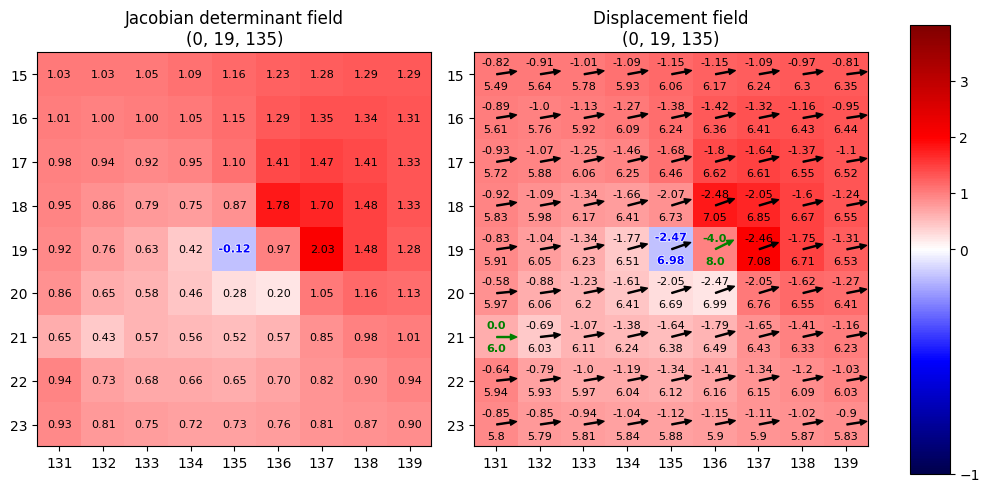



JDET INDEX: 5
(0, 10, 173) -0.04322329000574181
(0, 10, 182) -0.4615082473406252
(0, 14, 209) -0.18565176137380068
(0, 17, 213) -0.10382806479430441
(0, 19, 135) -0.12231073669278755
(0, 22, 127) -0.43775160808278074
(0, 54, 220) -0.01662967757469775
(0, 55, 222) -0.2094807825718189
(0, 58, 228) -0.1988870109366243
(0, 59, 229) -0.044633504475831226
(0, 116, 142) -0.0834511505923656
(0, 122, 316) -0.26293143368296906
(0, 124, 148) -0.07400007714216572
(0, 128, 136) -0.39328717612863245
(0, 134, 64) -0.04155411056144314
(0, 134, 153) -0.028463799192673056
(0, 139, 157) -0.000987044747038153
(0, 144, 209) -0.065683482403479
(0, 150, 245) -0.8647245957286207
(0, 151, 402) -0.12828712647346555
(0, 201, 180) -0.03980520071925282
(0, 222, 212) -0.05613230548972591
(0, 225, 143) -0.5461647730183096
(0, 232, 235) -0.3575078901120002
(0, 236, 201) -0.09607994258469835
(0, 238, 194) -0.04633665692235347
(0, 249, 58) -0.08626580725464024

Current Jdet coordinate index: 5
Number of negative Jdet

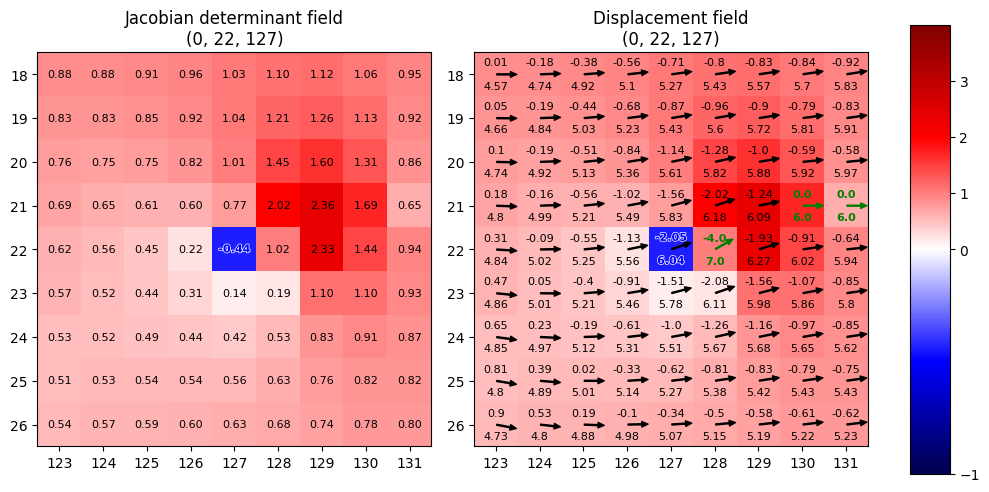



JDET INDEX: 6
(0, 10, 173) -0.04322329000574181
(0, 10, 182) -0.4615082473406252
(0, 14, 209) -0.18565176137380068
(0, 17, 213) -0.10382806479430441
(0, 19, 135) -0.12231073669278755
(0, 22, 127) -0.43775160808278074
(0, 54, 220) -0.01662967757469775
(0, 55, 222) -0.2094807825718189
(0, 58, 228) -0.1988870109366243
(0, 59, 229) -0.044633504475831226
(0, 116, 142) -0.0834511505923656
(0, 122, 316) -0.26293143368296906
(0, 124, 148) -0.07400007714216572
(0, 128, 136) -0.39328717612863245
(0, 134, 64) -0.04155411056144314
(0, 134, 153) -0.028463799192673056
(0, 139, 157) -0.000987044747038153
(0, 144, 209) -0.065683482403479
(0, 150, 245) -0.8647245957286207
(0, 151, 402) -0.12828712647346555
(0, 201, 180) -0.03980520071925282
(0, 222, 212) -0.05613230548972591
(0, 225, 143) -0.5461647730183096
(0, 232, 235) -0.3575078901120002
(0, 236, 201) -0.09607994258469835
(0, 238, 194) -0.04633665692235347
(0, 249, 58) -0.08626580725464024

Current Jdet coordinate index: 6
Number of negative Jdet

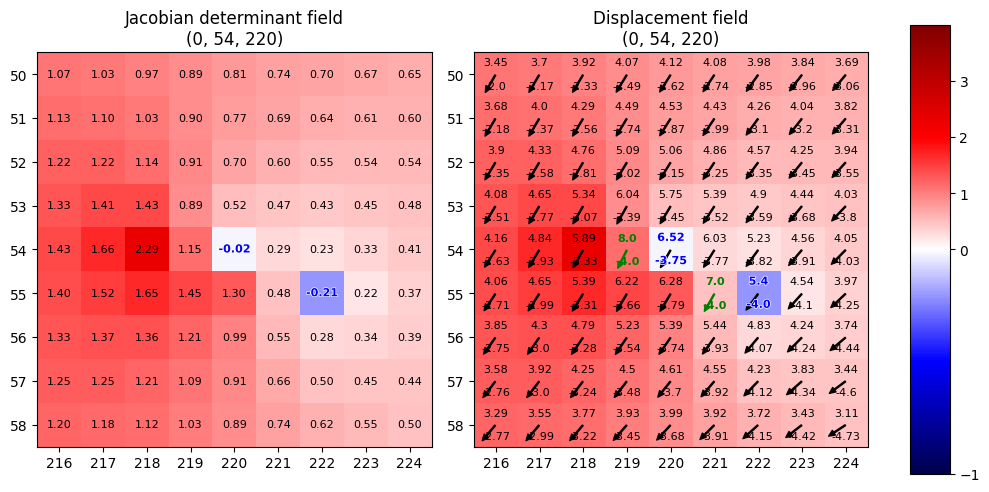



JDET INDEX: 7
(0, 10, 173) -0.04322329000574181
(0, 10, 182) -0.4615082473406252
(0, 14, 209) -0.18565176137380068
(0, 17, 213) -0.10382806479430441
(0, 19, 135) -0.12231073669278755
(0, 22, 127) -0.43775160808278074
(0, 54, 220) -0.01662967757469775
(0, 55, 222) -0.2094807825718189
(0, 58, 228) -0.1988870109366243
(0, 59, 229) -0.044633504475831226
(0, 116, 142) -0.0834511505923656
(0, 122, 316) -0.26293143368296906
(0, 124, 148) -0.07400007714216572
(0, 128, 136) -0.39328717612863245
(0, 134, 64) -0.04155411056144314
(0, 134, 153) -0.028463799192673056
(0, 139, 157) -0.000987044747038153
(0, 144, 209) -0.065683482403479
(0, 150, 245) -0.8647245957286207
(0, 151, 402) -0.12828712647346555
(0, 201, 180) -0.03980520071925282
(0, 222, 212) -0.05613230548972591
(0, 225, 143) -0.5461647730183096
(0, 232, 235) -0.3575078901120002
(0, 236, 201) -0.09607994258469835
(0, 238, 194) -0.04633665692235347
(0, 249, 58) -0.08626580725464024

Current Jdet coordinate index: 7
Number of negative Jdet

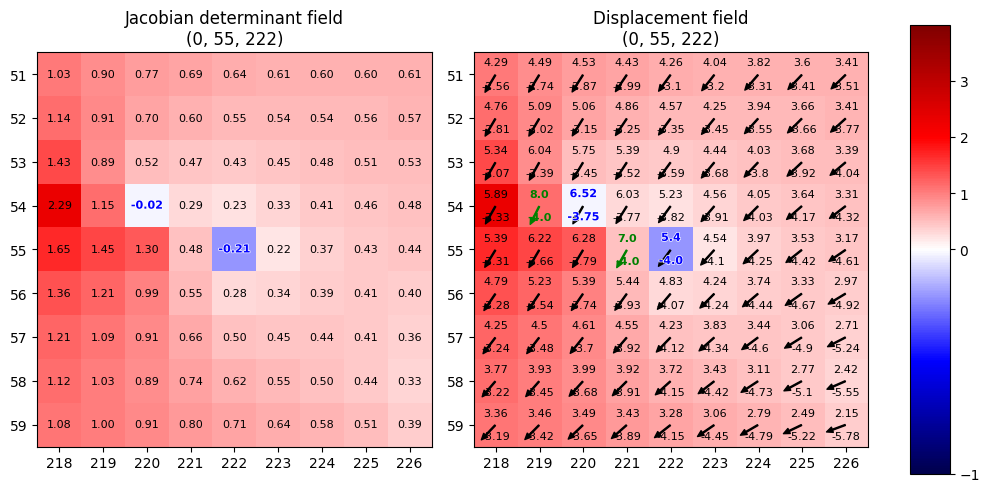



JDET INDEX: 8
(0, 10, 173) -0.04322329000574181
(0, 10, 182) -0.4615082473406252
(0, 14, 209) -0.18565176137380068
(0, 17, 213) -0.10382806479430441
(0, 19, 135) -0.12231073669278755
(0, 22, 127) -0.43775160808278074
(0, 54, 220) -0.01662967757469775
(0, 55, 222) -0.2094807825718189
(0, 58, 228) -0.1988870109366243
(0, 59, 229) -0.044633504475831226
(0, 116, 142) -0.0834511505923656
(0, 122, 316) -0.26293143368296906
(0, 124, 148) -0.07400007714216572
(0, 128, 136) -0.39328717612863245
(0, 134, 64) -0.04155411056144314
(0, 134, 153) -0.028463799192673056
(0, 139, 157) -0.000987044747038153
(0, 144, 209) -0.065683482403479
(0, 150, 245) -0.8647245957286207
(0, 151, 402) -0.12828712647346555
(0, 201, 180) -0.03980520071925282
(0, 222, 212) -0.05613230548972591
(0, 225, 143) -0.5461647730183096
(0, 232, 235) -0.3575078901120002
(0, 236, 201) -0.09607994258469835
(0, 238, 194) -0.04633665692235347
(0, 249, 58) -0.08626580725464024

Current Jdet coordinate index: 8
Number of negative Jdet

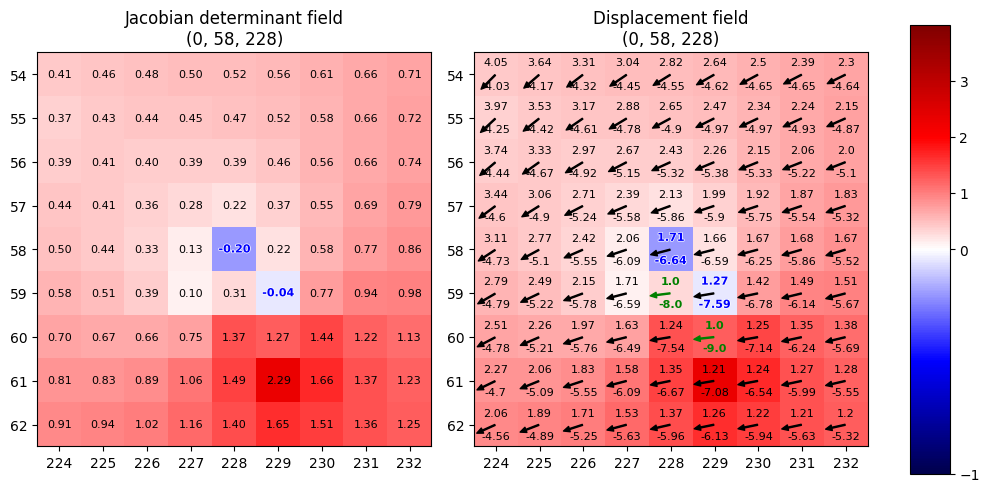



JDET INDEX: 9
(0, 10, 173) -0.04322329000574181
(0, 10, 182) -0.4615082473406252
(0, 14, 209) -0.18565176137380068
(0, 17, 213) -0.10382806479430441
(0, 19, 135) -0.12231073669278755
(0, 22, 127) -0.43775160808278074
(0, 54, 220) -0.01662967757469775
(0, 55, 222) -0.2094807825718189
(0, 58, 228) -0.1988870109366243
(0, 59, 229) -0.044633504475831226
(0, 116, 142) -0.0834511505923656
(0, 122, 316) -0.26293143368296906
(0, 124, 148) -0.07400007714216572
(0, 128, 136) -0.39328717612863245
(0, 134, 64) -0.04155411056144314
(0, 134, 153) -0.028463799192673056
(0, 139, 157) -0.000987044747038153
(0, 144, 209) -0.065683482403479
(0, 150, 245) -0.8647245957286207
(0, 151, 402) -0.12828712647346555
(0, 201, 180) -0.03980520071925282
(0, 222, 212) -0.05613230548972591
(0, 225, 143) -0.5461647730183096
(0, 232, 235) -0.3575078901120002
(0, 236, 201) -0.09607994258469835
(0, 238, 194) -0.04633665692235347
(0, 249, 58) -0.08626580725464024

Current Jdet coordinate index: 9
Number of negative Jdet

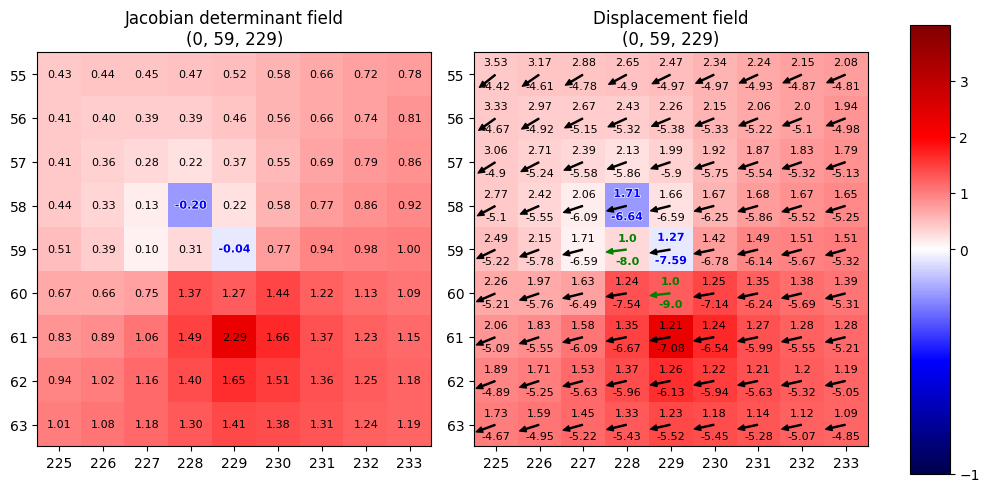



JDET INDEX: 10
(0, 10, 173) -0.04322329000574181
(0, 10, 182) -0.4615082473406252
(0, 14, 209) -0.18565176137380068
(0, 17, 213) -0.10382806479430441
(0, 19, 135) -0.12231073669278755
(0, 22, 127) -0.43775160808278074
(0, 54, 220) -0.01662967757469775
(0, 55, 222) -0.2094807825718189
(0, 58, 228) -0.1988870109366243
(0, 59, 229) -0.044633504475831226
(0, 116, 142) -0.0834511505923656
(0, 122, 316) -0.26293143368296906
(0, 124, 148) -0.07400007714216572
(0, 128, 136) -0.39328717612863245
(0, 134, 64) -0.04155411056144314
(0, 134, 153) -0.028463799192673056
(0, 139, 157) -0.000987044747038153
(0, 144, 209) -0.065683482403479
(0, 150, 245) -0.8647245957286207
(0, 151, 402) -0.12828712647346555
(0, 201, 180) -0.03980520071925282
(0, 222, 212) -0.05613230548972591
(0, 225, 143) -0.5461647730183096
(0, 232, 235) -0.3575078901120002
(0, 236, 201) -0.09607994258469835
(0, 238, 194) -0.04633665692235347
(0, 249, 58) -0.08626580725464024

Current Jdet coordinate index: 10
Number of negative Jd

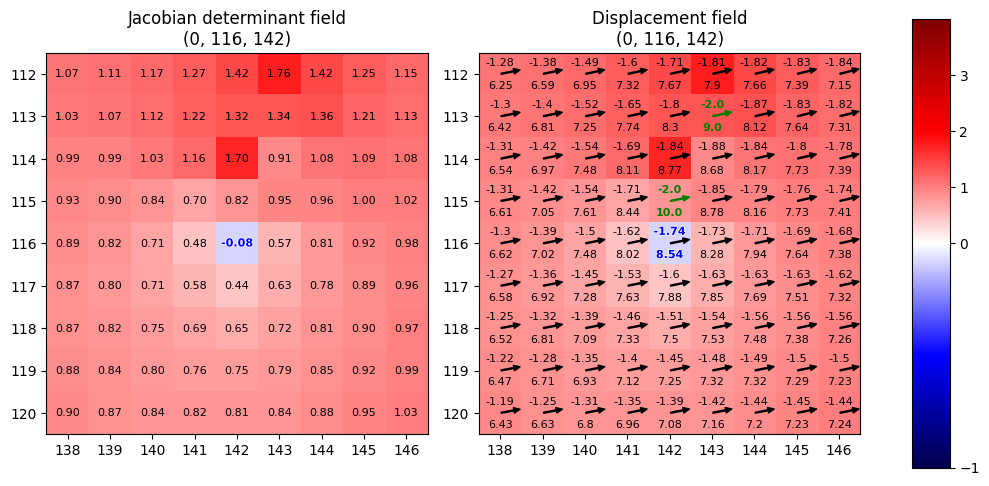



JDET INDEX: 11
(0, 10, 173) -0.04322329000574181
(0, 10, 182) -0.4615082473406252
(0, 14, 209) -0.18565176137380068
(0, 17, 213) -0.10382806479430441
(0, 19, 135) -0.12231073669278755
(0, 22, 127) -0.43775160808278074
(0, 54, 220) -0.01662967757469775
(0, 55, 222) -0.2094807825718189
(0, 58, 228) -0.1988870109366243
(0, 59, 229) -0.044633504475831226
(0, 116, 142) -0.0834511505923656
(0, 122, 316) -0.26293143368296906
(0, 124, 148) -0.07400007714216572
(0, 128, 136) -0.39328717612863245
(0, 134, 64) -0.04155411056144314
(0, 134, 153) -0.028463799192673056
(0, 139, 157) -0.000987044747038153
(0, 144, 209) -0.065683482403479
(0, 150, 245) -0.8647245957286207
(0, 151, 402) -0.12828712647346555
(0, 201, 180) -0.03980520071925282
(0, 222, 212) -0.05613230548972591
(0, 225, 143) -0.5461647730183096
(0, 232, 235) -0.3575078901120002
(0, 236, 201) -0.09607994258469835
(0, 238, 194) -0.04633665692235347
(0, 249, 58) -0.08626580725464024

Current Jdet coordinate index: 11
Number of negative Jd

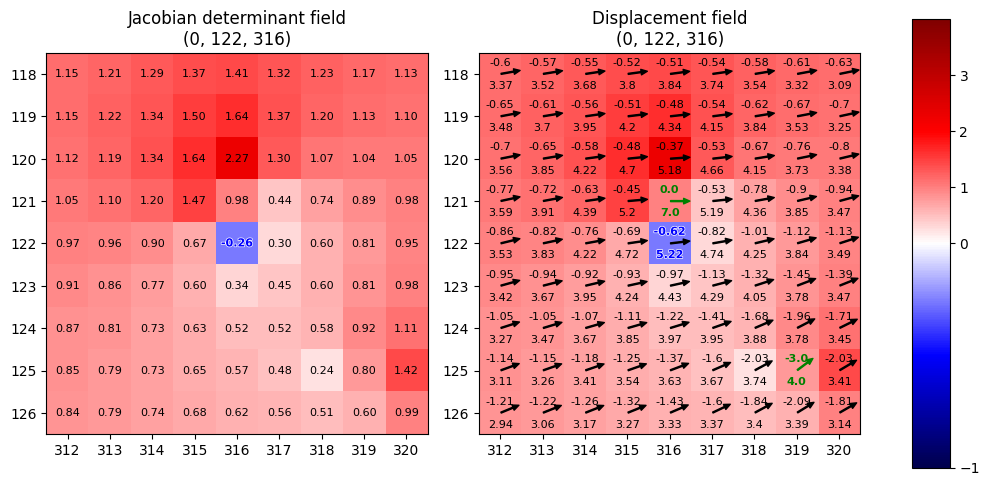



JDET INDEX: 12
(0, 10, 173) -0.04322329000574181
(0, 10, 182) -0.4615082473406252
(0, 14, 209) -0.18565176137380068
(0, 17, 213) -0.10382806479430441
(0, 19, 135) -0.12231073669278755
(0, 22, 127) -0.43775160808278074
(0, 54, 220) -0.01662967757469775
(0, 55, 222) -0.2094807825718189
(0, 58, 228) -0.1988870109366243
(0, 59, 229) -0.044633504475831226
(0, 116, 142) -0.0834511505923656
(0, 122, 316) -0.26293143368296906
(0, 124, 148) -0.07400007714216572
(0, 128, 136) -0.39328717612863245
(0, 134, 64) -0.04155411056144314
(0, 134, 153) -0.028463799192673056
(0, 139, 157) -0.000987044747038153
(0, 144, 209) -0.065683482403479
(0, 150, 245) -0.8647245957286207
(0, 151, 402) -0.12828712647346555
(0, 201, 180) -0.03980520071925282
(0, 222, 212) -0.05613230548972591
(0, 225, 143) -0.5461647730183096
(0, 232, 235) -0.3575078901120002
(0, 236, 201) -0.09607994258469835
(0, 238, 194) -0.04633665692235347
(0, 249, 58) -0.08626580725464024

Current Jdet coordinate index: 12
Number of negative Jd

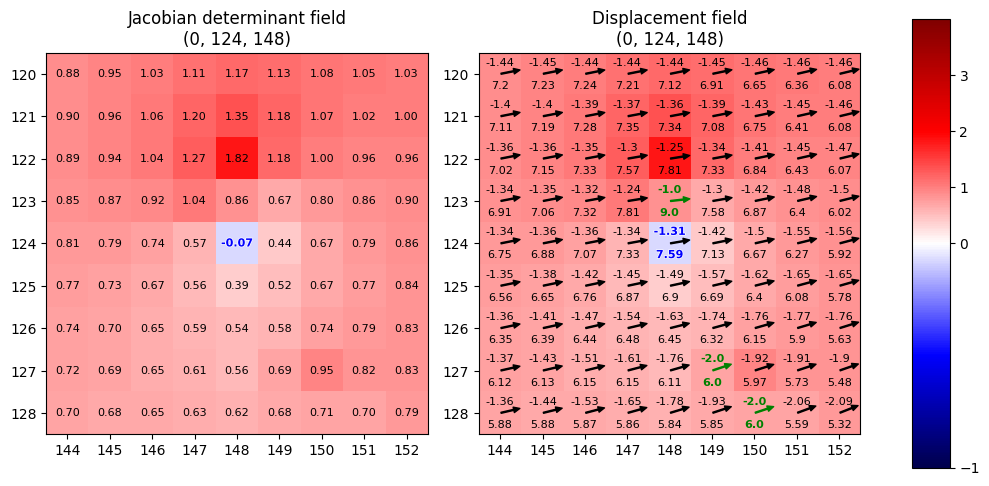



JDET INDEX: 13
(0, 10, 173) -0.04322329000574181
(0, 10, 182) -0.4615082473406252
(0, 14, 209) -0.18565176137380068
(0, 17, 213) -0.10382806479430441
(0, 19, 135) -0.12231073669278755
(0, 22, 127) -0.43775160808278074
(0, 54, 220) -0.01662967757469775
(0, 55, 222) -0.2094807825718189
(0, 58, 228) -0.1988870109366243
(0, 59, 229) -0.044633504475831226
(0, 116, 142) -0.0834511505923656
(0, 122, 316) -0.26293143368296906
(0, 124, 148) -0.07400007714216572
(0, 128, 136) -0.39328717612863245
(0, 134, 64) -0.04155411056144314
(0, 134, 153) -0.028463799192673056
(0, 139, 157) -0.000987044747038153
(0, 144, 209) -0.065683482403479
(0, 150, 245) -0.8647245957286207
(0, 151, 402) -0.12828712647346555
(0, 201, 180) -0.03980520071925282
(0, 222, 212) -0.05613230548972591
(0, 225, 143) -0.5461647730183096
(0, 232, 235) -0.3575078901120002
(0, 236, 201) -0.09607994258469835
(0, 238, 194) -0.04633665692235347
(0, 249, 58) -0.08626580725464024

Current Jdet coordinate index: 13
Number of negative Jd

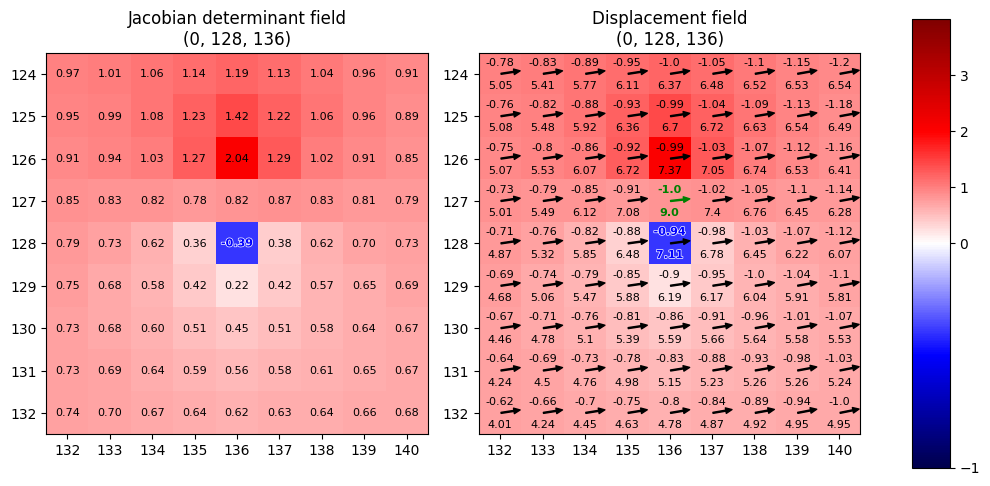



JDET INDEX: 14
(0, 10, 173) -0.04322329000574181
(0, 10, 182) -0.4615082473406252
(0, 14, 209) -0.18565176137380068
(0, 17, 213) -0.10382806479430441
(0, 19, 135) -0.12231073669278755
(0, 22, 127) -0.43775160808278074
(0, 54, 220) -0.01662967757469775
(0, 55, 222) -0.2094807825718189
(0, 58, 228) -0.1988870109366243
(0, 59, 229) -0.044633504475831226
(0, 116, 142) -0.0834511505923656
(0, 122, 316) -0.26293143368296906
(0, 124, 148) -0.07400007714216572
(0, 128, 136) -0.39328717612863245
(0, 134, 64) -0.04155411056144314
(0, 134, 153) -0.028463799192673056
(0, 139, 157) -0.000987044747038153
(0, 144, 209) -0.065683482403479
(0, 150, 245) -0.8647245957286207
(0, 151, 402) -0.12828712647346555
(0, 201, 180) -0.03980520071925282
(0, 222, 212) -0.05613230548972591
(0, 225, 143) -0.5461647730183096
(0, 232, 235) -0.3575078901120002
(0, 236, 201) -0.09607994258469835
(0, 238, 194) -0.04633665692235347
(0, 249, 58) -0.08626580725464024

Current Jdet coordinate index: 14
Number of negative Jd

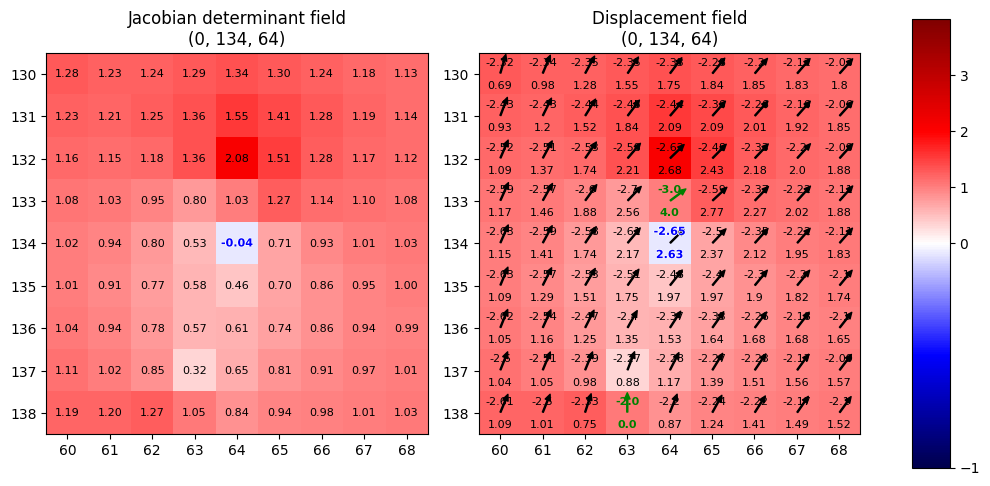



JDET INDEX: 15
(0, 10, 173) -0.04322329000574181
(0, 10, 182) -0.4615082473406252
(0, 14, 209) -0.18565176137380068
(0, 17, 213) -0.10382806479430441
(0, 19, 135) -0.12231073669278755
(0, 22, 127) -0.43775160808278074
(0, 54, 220) -0.01662967757469775
(0, 55, 222) -0.2094807825718189
(0, 58, 228) -0.1988870109366243
(0, 59, 229) -0.044633504475831226
(0, 116, 142) -0.0834511505923656
(0, 122, 316) -0.26293143368296906
(0, 124, 148) -0.07400007714216572
(0, 128, 136) -0.39328717612863245
(0, 134, 64) -0.04155411056144314
(0, 134, 153) -0.028463799192673056
(0, 139, 157) -0.000987044747038153
(0, 144, 209) -0.065683482403479
(0, 150, 245) -0.8647245957286207
(0, 151, 402) -0.12828712647346555
(0, 201, 180) -0.03980520071925282
(0, 222, 212) -0.05613230548972591
(0, 225, 143) -0.5461647730183096
(0, 232, 235) -0.3575078901120002
(0, 236, 201) -0.09607994258469835
(0, 238, 194) -0.04633665692235347
(0, 249, 58) -0.08626580725464024

Current Jdet coordinate index: 15
Number of negative Jd

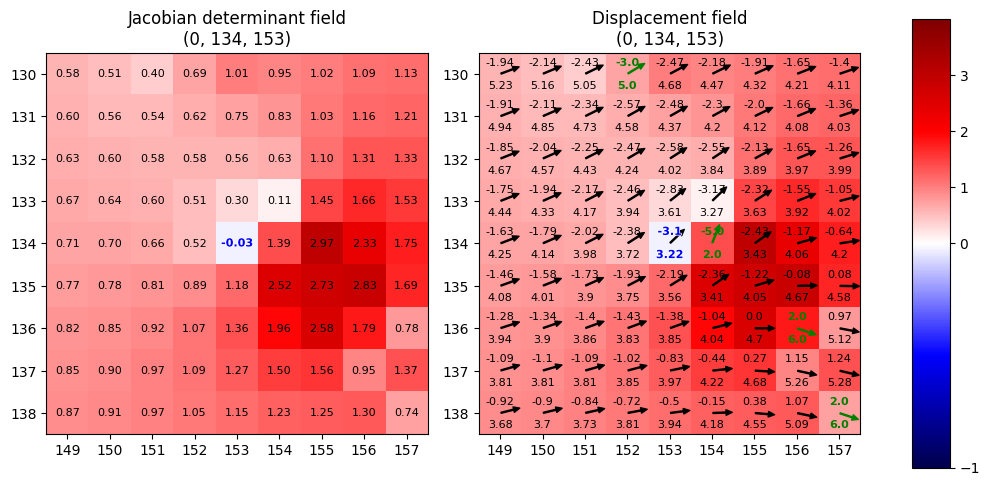



JDET INDEX: 16
(0, 10, 173) -0.04322329000574181
(0, 10, 182) -0.4615082473406252
(0, 14, 209) -0.18565176137380068
(0, 17, 213) -0.10382806479430441
(0, 19, 135) -0.12231073669278755
(0, 22, 127) -0.43775160808278074
(0, 54, 220) -0.01662967757469775
(0, 55, 222) -0.2094807825718189
(0, 58, 228) -0.1988870109366243
(0, 59, 229) -0.044633504475831226
(0, 116, 142) -0.0834511505923656
(0, 122, 316) -0.26293143368296906
(0, 124, 148) -0.07400007714216572
(0, 128, 136) -0.39328717612863245
(0, 134, 64) -0.04155411056144314
(0, 134, 153) -0.028463799192673056
(0, 139, 157) -0.000987044747038153
(0, 144, 209) -0.065683482403479
(0, 150, 245) -0.8647245957286207
(0, 151, 402) -0.12828712647346555
(0, 201, 180) -0.03980520071925282
(0, 222, 212) -0.05613230548972591
(0, 225, 143) -0.5461647730183096
(0, 232, 235) -0.3575078901120002
(0, 236, 201) -0.09607994258469835
(0, 238, 194) -0.04633665692235347
(0, 249, 58) -0.08626580725464024

Current Jdet coordinate index: 16
Number of negative Jd

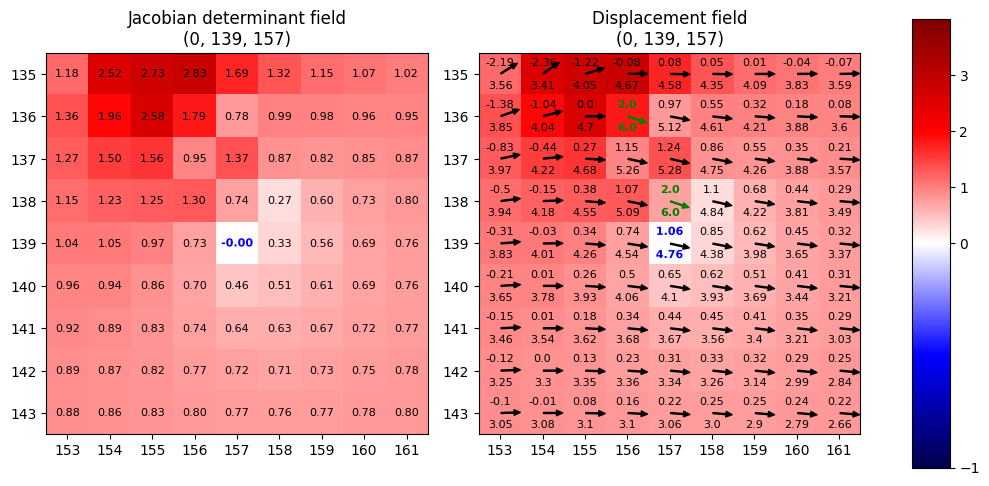



JDET INDEX: 17
(0, 10, 173) -0.04322329000574181
(0, 10, 182) -0.4615082473406252
(0, 14, 209) -0.18565176137380068
(0, 17, 213) -0.10382806479430441
(0, 19, 135) -0.12231073669278755
(0, 22, 127) -0.43775160808278074
(0, 54, 220) -0.01662967757469775
(0, 55, 222) -0.2094807825718189
(0, 58, 228) -0.1988870109366243
(0, 59, 229) -0.044633504475831226
(0, 116, 142) -0.0834511505923656
(0, 122, 316) -0.26293143368296906
(0, 124, 148) -0.07400007714216572
(0, 128, 136) -0.39328717612863245
(0, 134, 64) -0.04155411056144314
(0, 134, 153) -0.028463799192673056
(0, 139, 157) -0.000987044747038153
(0, 144, 209) -0.065683482403479
(0, 150, 245) -0.8647245957286207
(0, 151, 402) -0.12828712647346555
(0, 201, 180) -0.03980520071925282
(0, 222, 212) -0.05613230548972591
(0, 225, 143) -0.5461647730183096
(0, 232, 235) -0.3575078901120002
(0, 236, 201) -0.09607994258469835
(0, 238, 194) -0.04633665692235347
(0, 249, 58) -0.08626580725464024

Current Jdet coordinate index: 17
Number of negative Jd

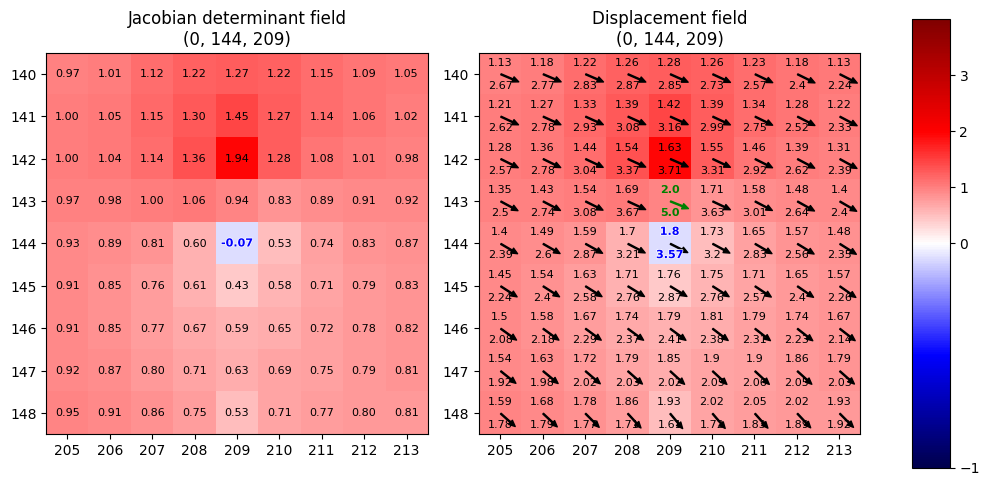



JDET INDEX: 18
(0, 10, 173) -0.04322329000574181
(0, 10, 182) -0.4615082473406252
(0, 14, 209) -0.18565176137380068
(0, 17, 213) -0.10382806479430441
(0, 19, 135) -0.12231073669278755
(0, 22, 127) -0.43775160808278074
(0, 54, 220) -0.01662967757469775
(0, 55, 222) -0.2094807825718189
(0, 58, 228) -0.1988870109366243
(0, 59, 229) -0.044633504475831226
(0, 116, 142) -0.0834511505923656
(0, 122, 316) -0.26293143368296906
(0, 124, 148) -0.07400007714216572
(0, 128, 136) -0.39328717612863245
(0, 134, 64) -0.04155411056144314
(0, 134, 153) -0.028463799192673056
(0, 139, 157) -0.000987044747038153
(0, 144, 209) -0.065683482403479
(0, 150, 245) -0.8647245957286207
(0, 151, 402) -0.12828712647346555
(0, 201, 180) -0.03980520071925282
(0, 222, 212) -0.05613230548972591
(0, 225, 143) -0.5461647730183096
(0, 232, 235) -0.3575078901120002
(0, 236, 201) -0.09607994258469835
(0, 238, 194) -0.04633665692235347
(0, 249, 58) -0.08626580725464024

Current Jdet coordinate index: 18
Number of negative Jd

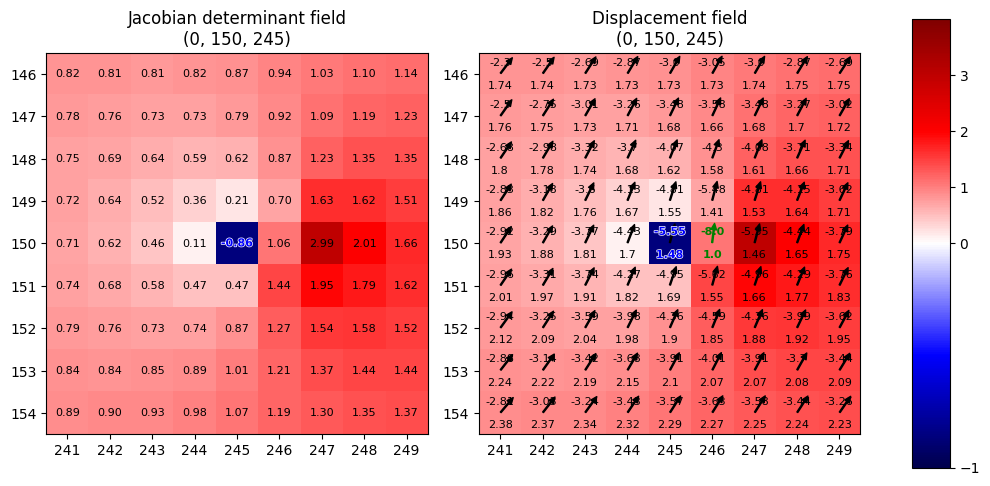



JDET INDEX: 19
(0, 10, 173) -0.04322329000574181
(0, 10, 182) -0.4615082473406252
(0, 14, 209) -0.18565176137380068
(0, 17, 213) -0.10382806479430441
(0, 19, 135) -0.12231073669278755
(0, 22, 127) -0.43775160808278074
(0, 54, 220) -0.01662967757469775
(0, 55, 222) -0.2094807825718189
(0, 58, 228) -0.1988870109366243
(0, 59, 229) -0.044633504475831226
(0, 116, 142) -0.0834511505923656
(0, 122, 316) -0.26293143368296906
(0, 124, 148) -0.07400007714216572
(0, 128, 136) -0.39328717612863245
(0, 134, 64) -0.04155411056144314
(0, 134, 153) -0.028463799192673056
(0, 139, 157) -0.000987044747038153
(0, 144, 209) -0.065683482403479
(0, 150, 245) -0.8647245957286207
(0, 151, 402) -0.12828712647346555
(0, 201, 180) -0.03980520071925282
(0, 222, 212) -0.05613230548972591
(0, 225, 143) -0.5461647730183096
(0, 232, 235) -0.3575078901120002
(0, 236, 201) -0.09607994258469835
(0, 238, 194) -0.04633665692235347
(0, 249, 58) -0.08626580725464024

Current Jdet coordinate index: 19
Number of negative Jd

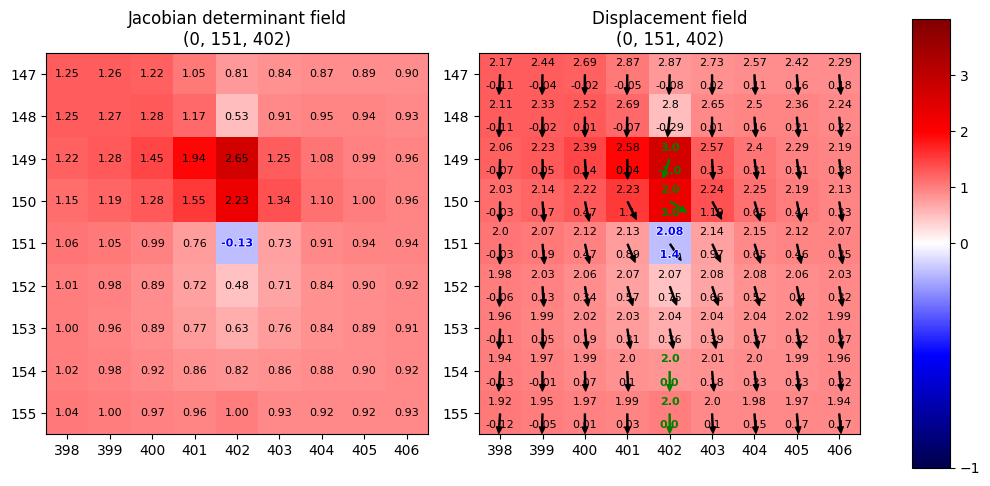



JDET INDEX: 20
(0, 10, 173) -0.04322329000574181
(0, 10, 182) -0.4615082473406252
(0, 14, 209) -0.18565176137380068
(0, 17, 213) -0.10382806479430441
(0, 19, 135) -0.12231073669278755
(0, 22, 127) -0.43775160808278074
(0, 54, 220) -0.01662967757469775
(0, 55, 222) -0.2094807825718189
(0, 58, 228) -0.1988870109366243
(0, 59, 229) -0.044633504475831226
(0, 116, 142) -0.0834511505923656
(0, 122, 316) -0.26293143368296906
(0, 124, 148) -0.07400007714216572
(0, 128, 136) -0.39328717612863245
(0, 134, 64) -0.04155411056144314
(0, 134, 153) -0.028463799192673056
(0, 139, 157) -0.000987044747038153
(0, 144, 209) -0.065683482403479
(0, 150, 245) -0.8647245957286207
(0, 151, 402) -0.12828712647346555
(0, 201, 180) -0.03980520071925282
(0, 222, 212) -0.05613230548972591
(0, 225, 143) -0.5461647730183096
(0, 232, 235) -0.3575078901120002
(0, 236, 201) -0.09607994258469835
(0, 238, 194) -0.04633665692235347
(0, 249, 58) -0.08626580725464024

Current Jdet coordinate index: 20
Number of negative Jd

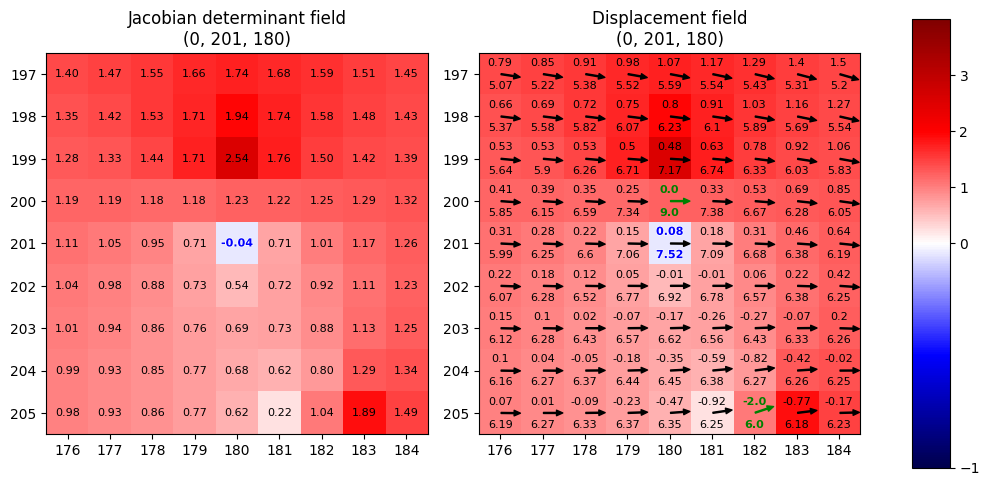



JDET INDEX: 21
(0, 10, 173) -0.04322329000574181
(0, 10, 182) -0.4615082473406252
(0, 14, 209) -0.18565176137380068
(0, 17, 213) -0.10382806479430441
(0, 19, 135) -0.12231073669278755
(0, 22, 127) -0.43775160808278074
(0, 54, 220) -0.01662967757469775
(0, 55, 222) -0.2094807825718189
(0, 58, 228) -0.1988870109366243
(0, 59, 229) -0.044633504475831226
(0, 116, 142) -0.0834511505923656
(0, 122, 316) -0.26293143368296906
(0, 124, 148) -0.07400007714216572
(0, 128, 136) -0.39328717612863245
(0, 134, 64) -0.04155411056144314
(0, 134, 153) -0.028463799192673056
(0, 139, 157) -0.000987044747038153
(0, 144, 209) -0.065683482403479
(0, 150, 245) -0.8647245957286207
(0, 151, 402) -0.12828712647346555
(0, 201, 180) -0.03980520071925282
(0, 222, 212) -0.05613230548972591
(0, 225, 143) -0.5461647730183096
(0, 232, 235) -0.3575078901120002
(0, 236, 201) -0.09607994258469835
(0, 238, 194) -0.04633665692235347
(0, 249, 58) -0.08626580725464024

Current Jdet coordinate index: 21
Number of negative Jd

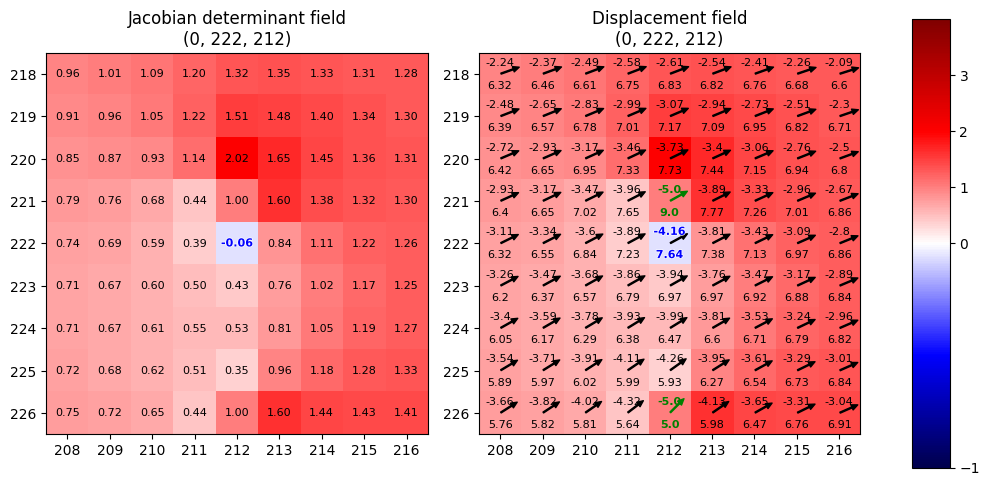



JDET INDEX: 22
(0, 10, 173) -0.04322329000574181
(0, 10, 182) -0.4615082473406252
(0, 14, 209) -0.18565176137380068
(0, 17, 213) -0.10382806479430441
(0, 19, 135) -0.12231073669278755
(0, 22, 127) -0.43775160808278074
(0, 54, 220) -0.01662967757469775
(0, 55, 222) -0.2094807825718189
(0, 58, 228) -0.1988870109366243
(0, 59, 229) -0.044633504475831226
(0, 116, 142) -0.0834511505923656
(0, 122, 316) -0.26293143368296906
(0, 124, 148) -0.07400007714216572
(0, 128, 136) -0.39328717612863245
(0, 134, 64) -0.04155411056144314
(0, 134, 153) -0.028463799192673056
(0, 139, 157) -0.000987044747038153
(0, 144, 209) -0.065683482403479
(0, 150, 245) -0.8647245957286207
(0, 151, 402) -0.12828712647346555
(0, 201, 180) -0.03980520071925282
(0, 222, 212) -0.05613230548972591
(0, 225, 143) -0.5461647730183096
(0, 232, 235) -0.3575078901120002
(0, 236, 201) -0.09607994258469835
(0, 238, 194) -0.04633665692235347
(0, 249, 58) -0.08626580725464024

Current Jdet coordinate index: 22
Number of negative Jd

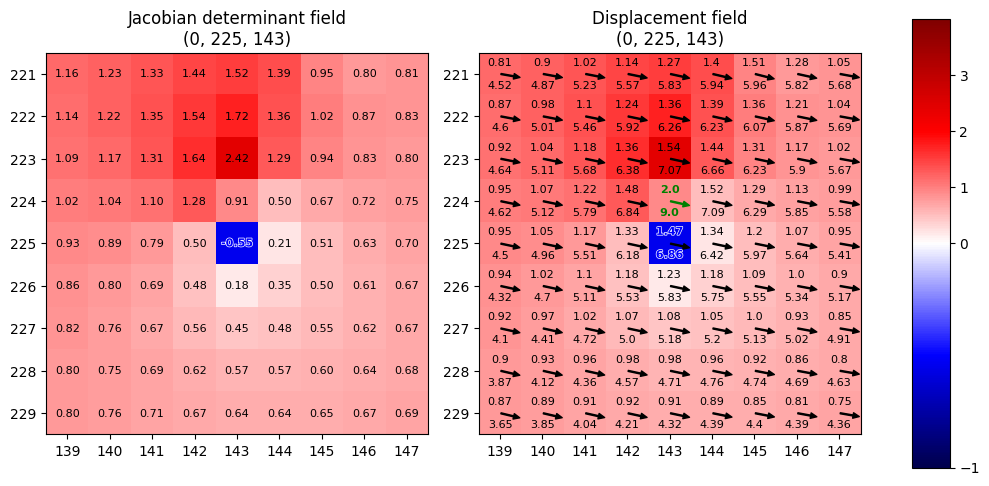



JDET INDEX: 23
(0, 10, 173) -0.04322329000574181
(0, 10, 182) -0.4615082473406252
(0, 14, 209) -0.18565176137380068
(0, 17, 213) -0.10382806479430441
(0, 19, 135) -0.12231073669278755
(0, 22, 127) -0.43775160808278074
(0, 54, 220) -0.01662967757469775
(0, 55, 222) -0.2094807825718189
(0, 58, 228) -0.1988870109366243
(0, 59, 229) -0.044633504475831226
(0, 116, 142) -0.0834511505923656
(0, 122, 316) -0.26293143368296906
(0, 124, 148) -0.07400007714216572
(0, 128, 136) -0.39328717612863245
(0, 134, 64) -0.04155411056144314
(0, 134, 153) -0.028463799192673056
(0, 139, 157) -0.000987044747038153
(0, 144, 209) -0.065683482403479
(0, 150, 245) -0.8647245957286207
(0, 151, 402) -0.12828712647346555
(0, 201, 180) -0.03980520071925282
(0, 222, 212) -0.05613230548972591
(0, 225, 143) -0.5461647730183096
(0, 232, 235) -0.3575078901120002
(0, 236, 201) -0.09607994258469835
(0, 238, 194) -0.04633665692235347
(0, 249, 58) -0.08626580725464024

Current Jdet coordinate index: 23
Number of negative Jd

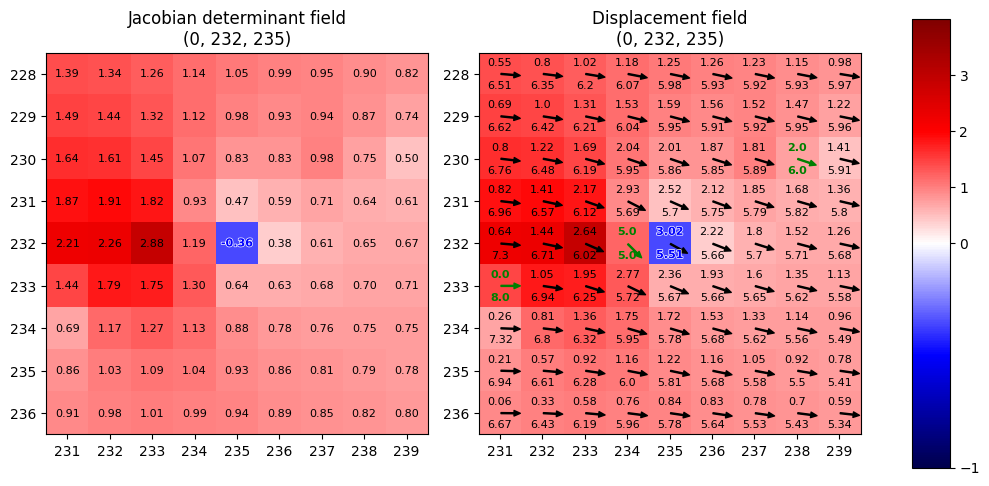



JDET INDEX: 24
(0, 10, 173) -0.04322329000574181
(0, 10, 182) -0.4615082473406252
(0, 14, 209) -0.18565176137380068
(0, 17, 213) -0.10382806479430441
(0, 19, 135) -0.12231073669278755
(0, 22, 127) -0.43775160808278074
(0, 54, 220) -0.01662967757469775
(0, 55, 222) -0.2094807825718189
(0, 58, 228) -0.1988870109366243
(0, 59, 229) -0.044633504475831226
(0, 116, 142) -0.0834511505923656
(0, 122, 316) -0.26293143368296906
(0, 124, 148) -0.07400007714216572
(0, 128, 136) -0.39328717612863245
(0, 134, 64) -0.04155411056144314
(0, 134, 153) -0.028463799192673056
(0, 139, 157) -0.000987044747038153
(0, 144, 209) -0.065683482403479
(0, 150, 245) -0.8647245957286207
(0, 151, 402) -0.12828712647346555
(0, 201, 180) -0.03980520071925282
(0, 222, 212) -0.05613230548972591
(0, 225, 143) -0.5461647730183096
(0, 232, 235) -0.3575078901120002
(0, 236, 201) -0.09607994258469835
(0, 238, 194) -0.04633665692235347
(0, 249, 58) -0.08626580725464024

Current Jdet coordinate index: 24
Number of negative Jd

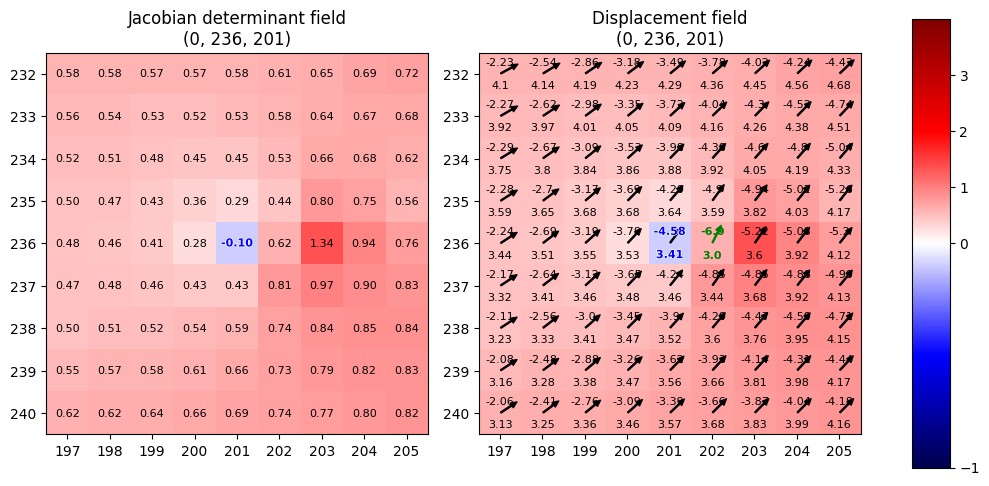



JDET INDEX: 25
(0, 10, 173) -0.04322329000574181
(0, 10, 182) -0.4615082473406252
(0, 14, 209) -0.18565176137380068
(0, 17, 213) -0.10382806479430441
(0, 19, 135) -0.12231073669278755
(0, 22, 127) -0.43775160808278074
(0, 54, 220) -0.01662967757469775
(0, 55, 222) -0.2094807825718189
(0, 58, 228) -0.1988870109366243
(0, 59, 229) -0.044633504475831226
(0, 116, 142) -0.0834511505923656
(0, 122, 316) -0.26293143368296906
(0, 124, 148) -0.07400007714216572
(0, 128, 136) -0.39328717612863245
(0, 134, 64) -0.04155411056144314
(0, 134, 153) -0.028463799192673056
(0, 139, 157) -0.000987044747038153
(0, 144, 209) -0.065683482403479
(0, 150, 245) -0.8647245957286207
(0, 151, 402) -0.12828712647346555
(0, 201, 180) -0.03980520071925282
(0, 222, 212) -0.05613230548972591
(0, 225, 143) -0.5461647730183096
(0, 232, 235) -0.3575078901120002
(0, 236, 201) -0.09607994258469835
(0, 238, 194) -0.04633665692235347
(0, 249, 58) -0.08626580725464024

Current Jdet coordinate index: 25
Number of negative Jd

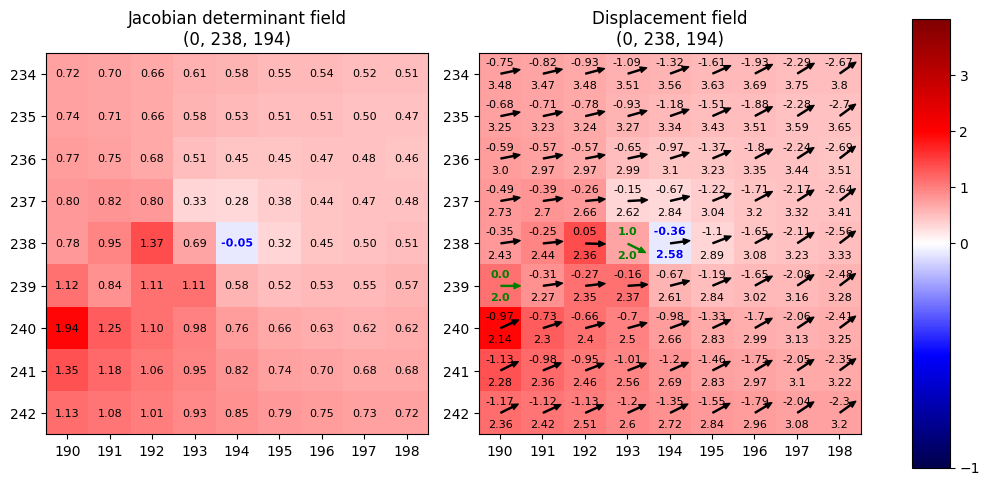



JDET INDEX: 26
(0, 10, 173) -0.04322329000574181
(0, 10, 182) -0.4615082473406252
(0, 14, 209) -0.18565176137380068
(0, 17, 213) -0.10382806479430441
(0, 19, 135) -0.12231073669278755
(0, 22, 127) -0.43775160808278074
(0, 54, 220) -0.01662967757469775
(0, 55, 222) -0.2094807825718189
(0, 58, 228) -0.1988870109366243
(0, 59, 229) -0.044633504475831226
(0, 116, 142) -0.0834511505923656
(0, 122, 316) -0.26293143368296906
(0, 124, 148) -0.07400007714216572
(0, 128, 136) -0.39328717612863245
(0, 134, 64) -0.04155411056144314
(0, 134, 153) -0.028463799192673056
(0, 139, 157) -0.000987044747038153
(0, 144, 209) -0.065683482403479
(0, 150, 245) -0.8647245957286207
(0, 151, 402) -0.12828712647346555
(0, 201, 180) -0.03980520071925282
(0, 222, 212) -0.05613230548972591
(0, 225, 143) -0.5461647730183096
(0, 232, 235) -0.3575078901120002
(0, 236, 201) -0.09607994258469835
(0, 238, 194) -0.04633665692235347
(0, 249, 58) -0.08626580725464024

Current Jdet coordinate index: 26
Number of negative Jd

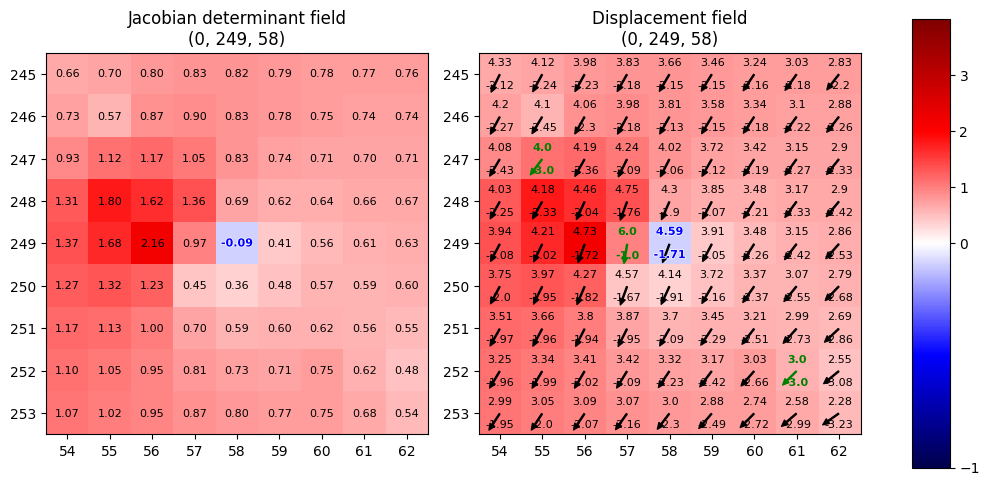

In [62]:
jdet_idx = 0

for i in range(27):
    jdet_idx = i
    print("JDET INDEX:", jdet_idx)
    # Get the coordinates of the negative Jacobian determinants
    negative_jdet_coords = get_negative_jdet_coords(jdet_corrected)
    for coord in negative_jdet_coords:
        coord = tuple(coord)
        info_str = str(coord) + " " + str(jdet_corrected[coord])
        print(info_str)
    print()
    print("Current Jdet coordinate index:", jdet_idx)
    print("Number of negative Jdet coords:", len(negative_jdet_coords))


    # Analyze a sample negative Jacobian determinant coordinate
    sample_coord = negative_jdet_coords[jdet_idx]
    print("Negative Jacobian determinant coordinate:", sample_coord)
    jacobian.surrounding_points(sample_coord, deformation_corrected, jdet_corrected)
    show_point(sample_coord, deformation_corrected, jdet_corrected, fpoints=fpoints_corrected, n=9)
    print()
    print()